# Introduction

Sunspots are regions on the sun's surface that are cooler than the surrounding areas and so appear darker. Sunspots have been observed continuously since 1609, and the first observation dates back a 100 years in china, If sunspots are active, more solar flares will result creating an increase in geomagnetic storm activity for Earth. Therefore during sunspot maximums, the Earth will see an increase in the Northern and Southern Lights and a possible disruption in radio transmissions and power grids.


In [242]:
from IPython.display import YouTubeVideo 
YouTubeVideo('rx9m6H6GeLs', width=1000, height=400) # Relevant till 3:00

# Imports

In [303]:
%load_ext autoreload
%autoreload 2
# Data Wrangling & stats
import pandas as pd

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Helper Handles
from helperhandler import dataHolder
from helperhandler import get_ts_strength, adf_test, kpss_test
from helperhandler import ro_framework, residual_diagnostic

# Models & Stats
from scipy.stats import boxcox
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.seasonal import STL
from statsmodels.stats.stattools import durbin_watson, jarque_bera
from statsmodels.graphics.gofplots import qqplot
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from fbprophet import Prophet


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Path and Variable Initialisations

In [249]:
root_path = '../'
raw_datapath = root_path+'Raw Data/'
prepared_datapath = root_path+'Prepared Data/'

In [250]:
plt.rcParams['figure.dpi'] = 100
plt.rcParams['figure.figsize'] = (15,7)
plt.style.use('dark_background')
# plt.style.use('ggplot')

# Load and Explore the Data

[Forecasting with long seasonal periods](https://robjhyndman.com/hyndsight/longseasonality/)

In [273]:
dataHolder.load_data()
dataHolder.dataDf.tail()

Handle       Short Description
10  anti_diabetic  AntiDiabetic Drug Sale
11   aus_elecprod  Electricity Production
12    visitor_20r  Visitors to 20 Regions
13   usa_economic    USA Economic Numbers
14       sunspots         Sunspot Numbers

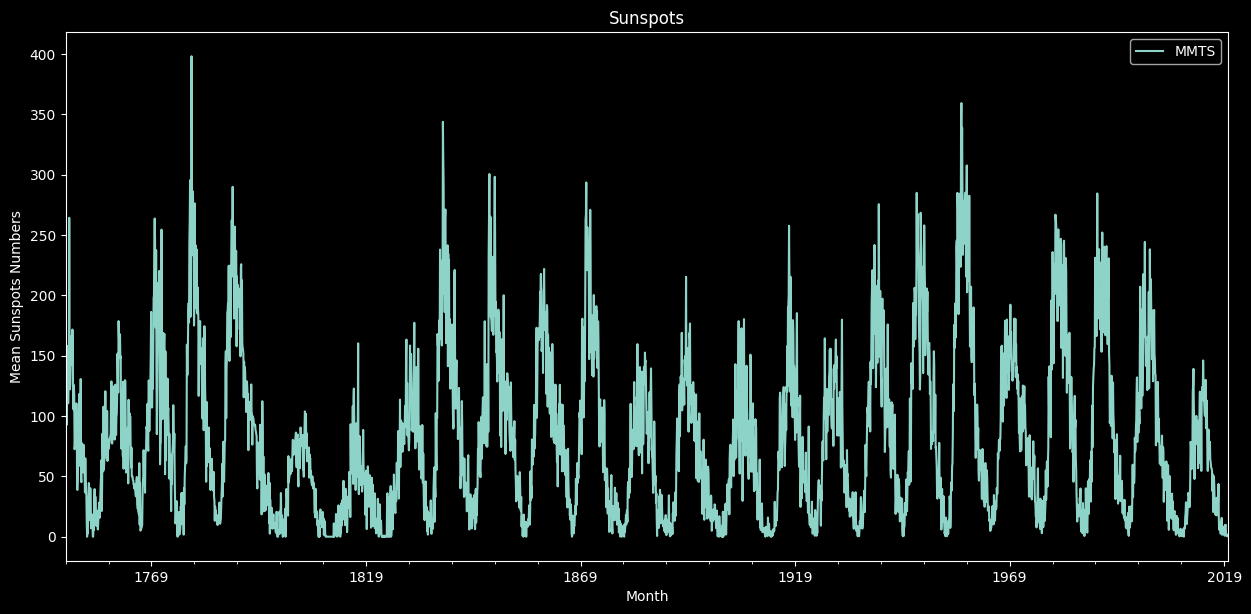

In [274]:
dataobj = dataHolder.bucket['sunspots']
sundata = dataobj.data.copy()
dataHolder.bucket['sunspots'].exploratory_plot()

In [275]:
sundata.index.freq = 'M'
sundata.head()

MMTS
Month            
1749-01-31   96.7
1749-02-28  104.3
1749-03-31  116.7
1749-04-30   92.8
1749-05-31  141.7

# In-Depth Exploratory Data Analysis & Data Preperation

## Time Series Plot

Try slicing the data and see if you can find the following properties, and quantify them :
- Monthly Seasonality
- Cyclicity

Starting from 12, 24, 36... 11 years=122, 12 years = 144

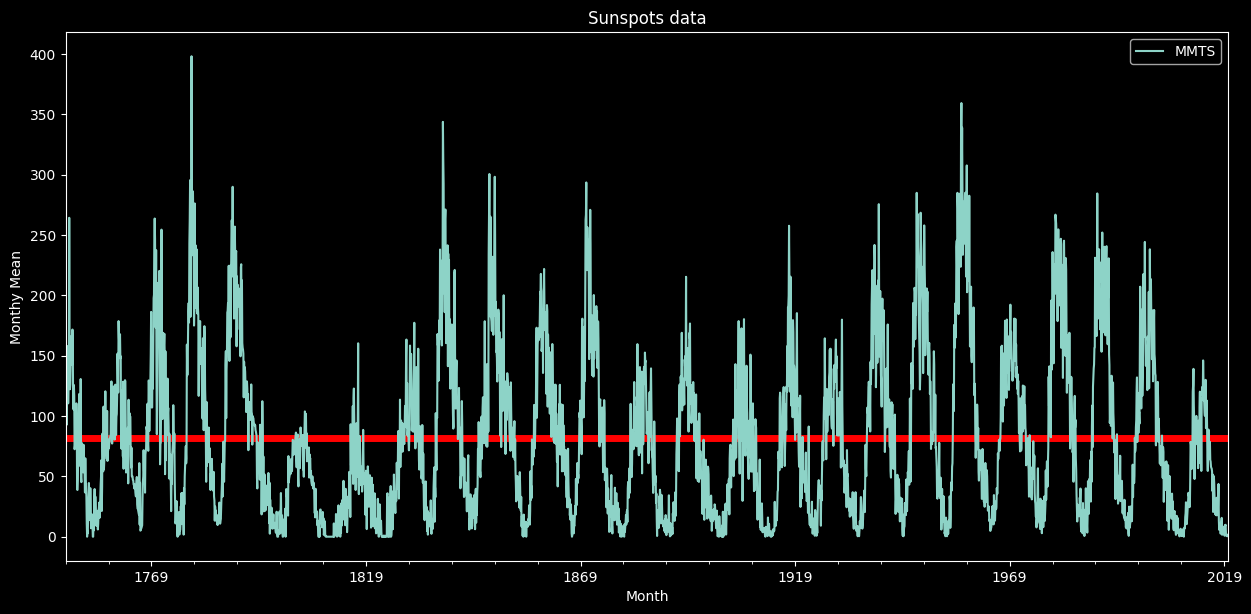

In [276]:
_=sundata.plot(title='Sunspots data', ylabel='Monthy Mean')
_=plt.hlines(sundata.mean(), label='mean', linewidth=5,
             xmin = sundata.index.min(),
             xmax = sundata.index.max(), color='red')

In [277]:
sundata.mean()

MMTS    82.070695
dtype: float64

## NaNs and Zeros in the data

In [278]:
(sundata==np.nan).sum()

MMTS    0
dtype: int64

In [279]:
(sundata==0.0).sum()

MMTS    67
dtype: int64

<b>There are 67 0.0 in the dataset, which are not supposed to be `Wrong` or `Outliers`  but can be problematic in later stages, how about we try to impute that?</b>

Were we to keep this :-

- We wont be able to use `MAPE` as our metric, which we are going to use
- We wont be able to apply some of the transformations to it

Maybe with the next smallest value in the series??

In [280]:
sorted(sundata.MMTS.unique())[:10]

[0.0, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

In [281]:
next_min = 0.2
sundata.replace({0.0:next_min}).min()

MMTS    0.2
dtype: float64

In [282]:
sundata=sundata.replace({0.0:next_min})

<b>Lets see how our Time Series looks now</b>

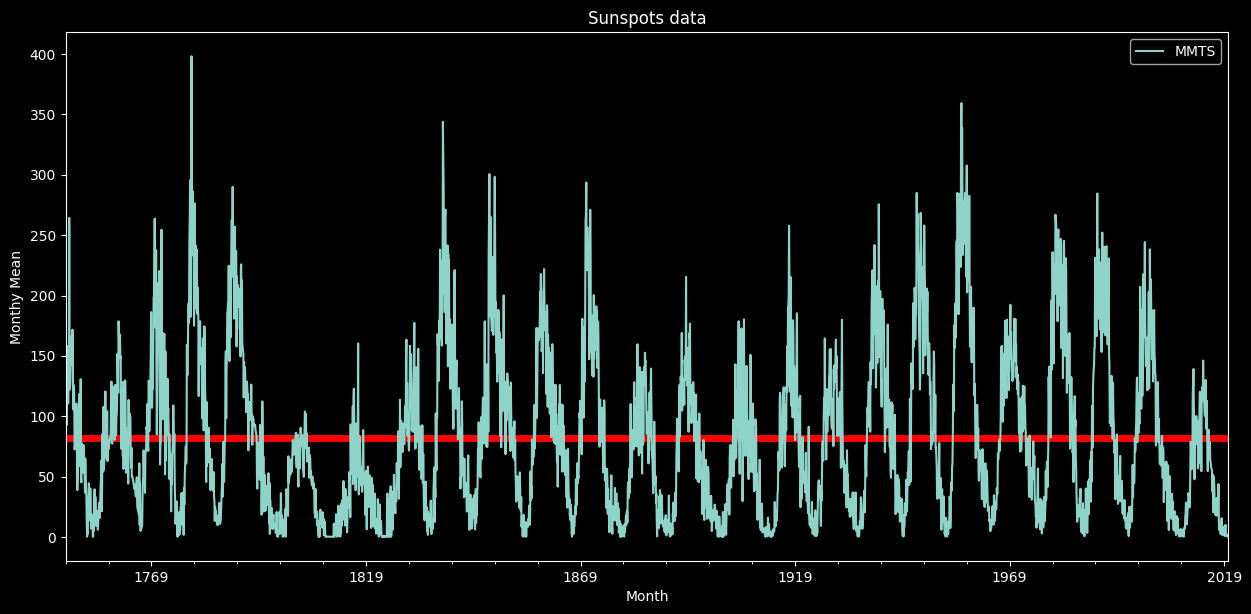

In [283]:
_=sundata.plot(title='Sunspots data', ylabel='Monthy Mean')
_=plt.hlines(sundata.mean(), label='mean', linewidth=5,
             xmin = sundata.index.min(),
             xmax = sundata.index.max(), color='red')

In [284]:
sundata.mean()

MMTS    82.074815
dtype: float64

## Distribution of the data

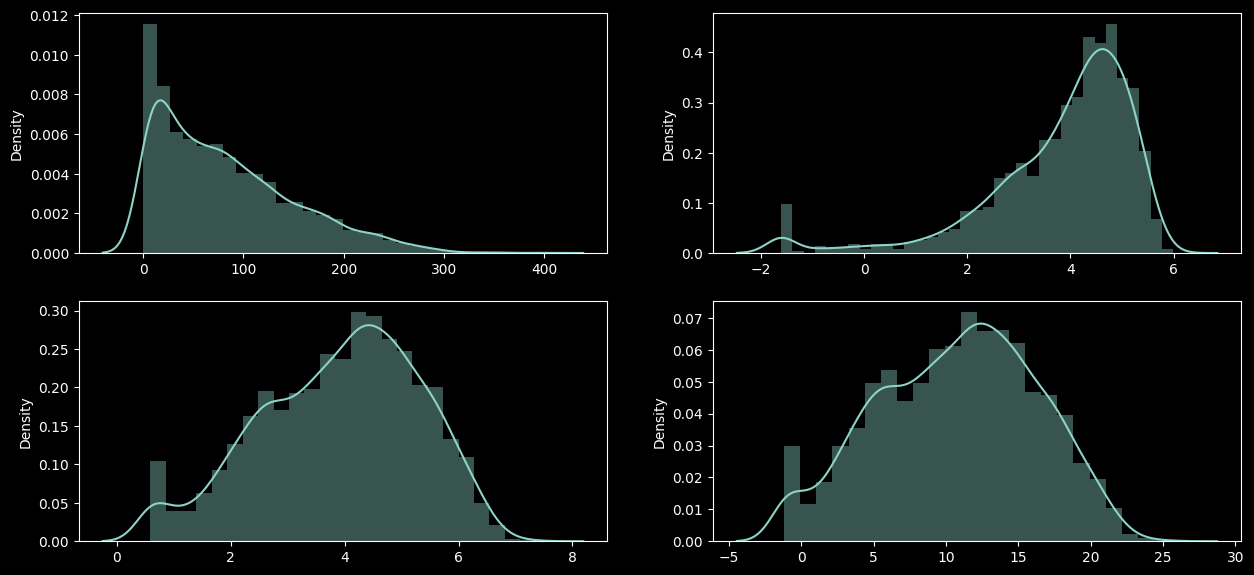

In [324]:
fig, axes = plt.subplots(2,2)
a,b=boxcox(sundata.MMTS)
_=sns.distplot(sundata, ax=axes[0,0])
_=sns.distplot(np.log(sundata), ax=axes[0,1])
_=sns.distplot(np.power(sundata,1/3), ax=axes[1,0])
_=sns.distplot(a, ax=axes[1,1])

## Transformation on the data

In [312]:
pltdata = sundata.copy()

In [313]:
pltdata['MMTS_Adj'] = pltdata.MMTS/pltdata.index.daysinmonth
pltdata.head()

MMTS  MMTS_Adj
Month                      
1749-01-31   96.7  3.119355
1749-02-28  104.3  3.725000
1749-03-31  116.7  3.764516
1749-04-30   92.8  3.093333
1749-05-31  141.7  4.570968

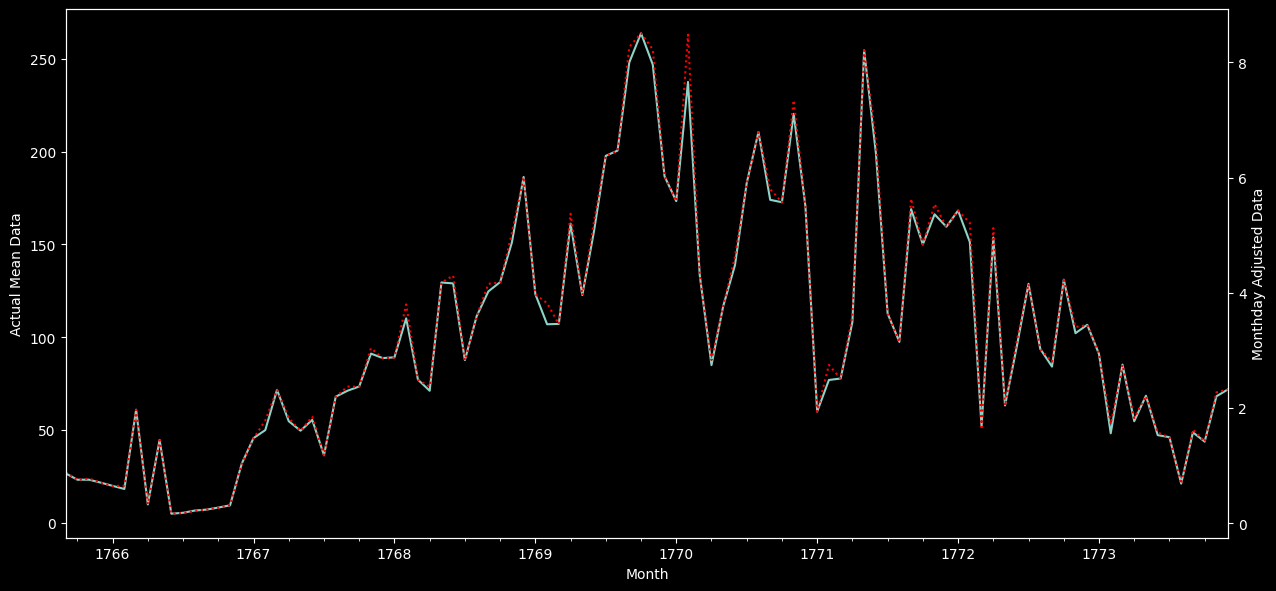

In [315]:
pltdata = pltdata[200:300]
fig, axes=plt.subplots()
_=pltdata.MMTS.plot(ax=axes)
_=axes.set_ylabel('Actual Mean Data')
dx = axes.twinx()
_=pltdata.MMTS_Adj.plot(ax=dx, color='red', linestyle=':')
_=dx.set_ylabel('Monthday Adjusted Data')

<b>Log Transformation</b>

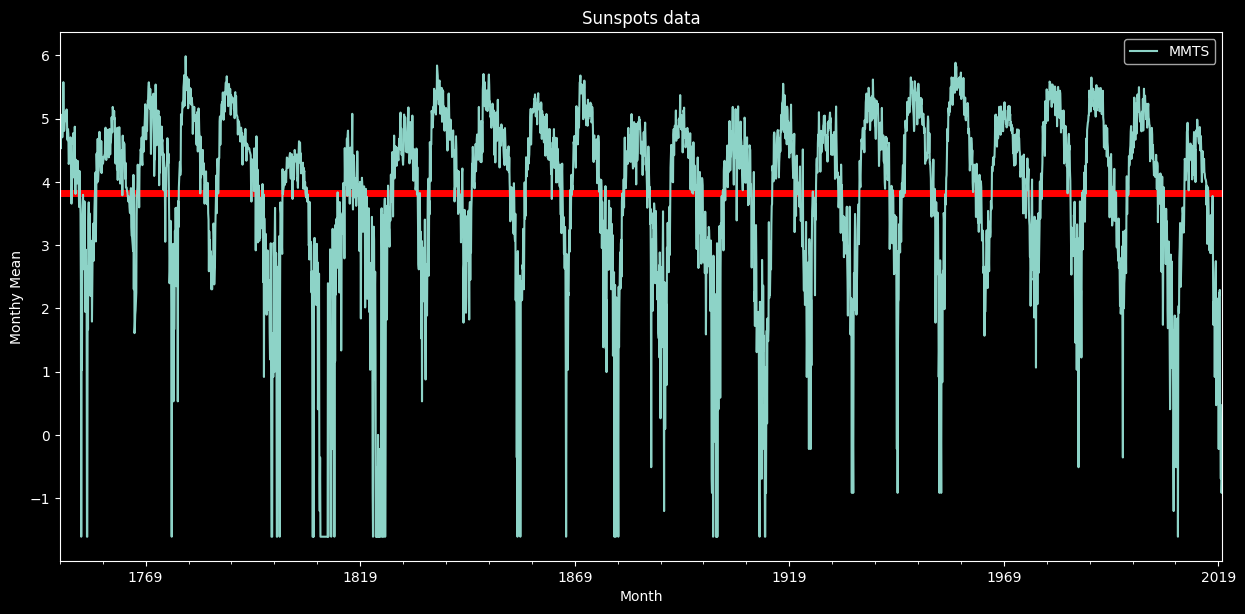

In [316]:
_=np.log(sundata).plot(title='Sunspots data', ylabel='Monthy Mean')
_=plt.hlines(np.log(sundata).mean(), label='mean', linewidth=5,
             xmin = sundata.index.min(),
             xmax = sundata.index.max(), color='red')

<b>Cube Root Transformation</b>

In [325]:
transformed_series = np.power(sundata.MMTS, 1/3)

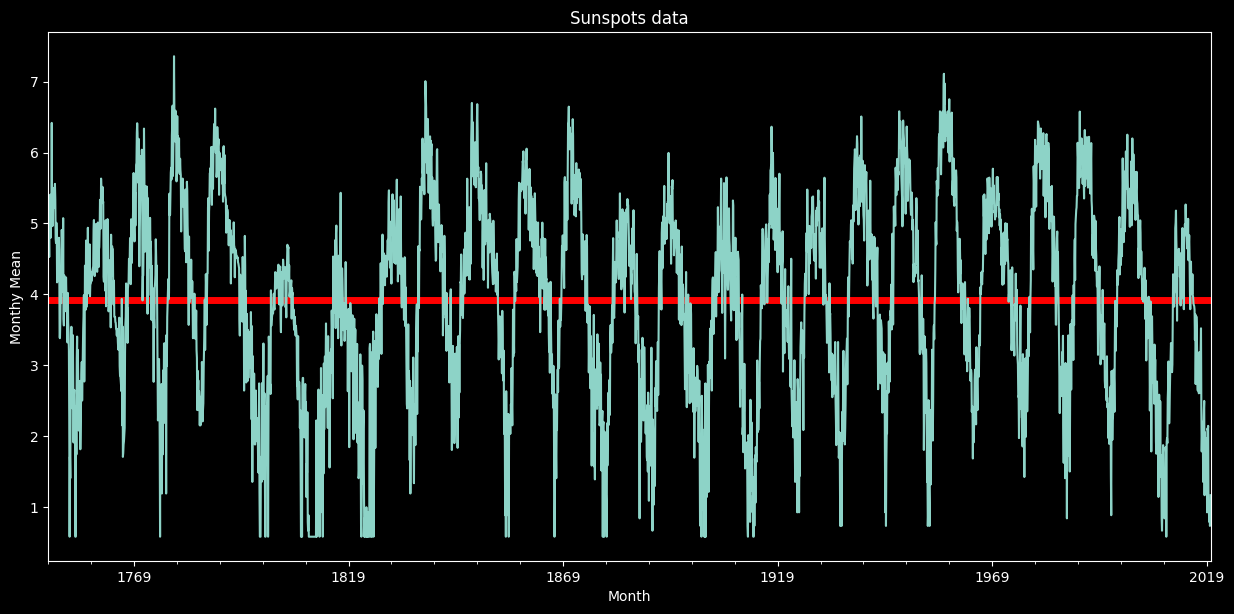

In [326]:
_=transformed_series.plot(title='Sunspots data', ylabel='Monthy Mean')
_=plt.hlines(transformed_series.mean(), label='mean', linewidth=5,
             xmin = sundata.index.min(),
             xmax = sundata.index.max(), color='red')

<b>BoxCox Transformations</b>

In [322]:
transformed_series, bc_lambda = boxcox(sundata.MMTS)
transformed_series = pd.Series(transformed_series, index=sundata.index)

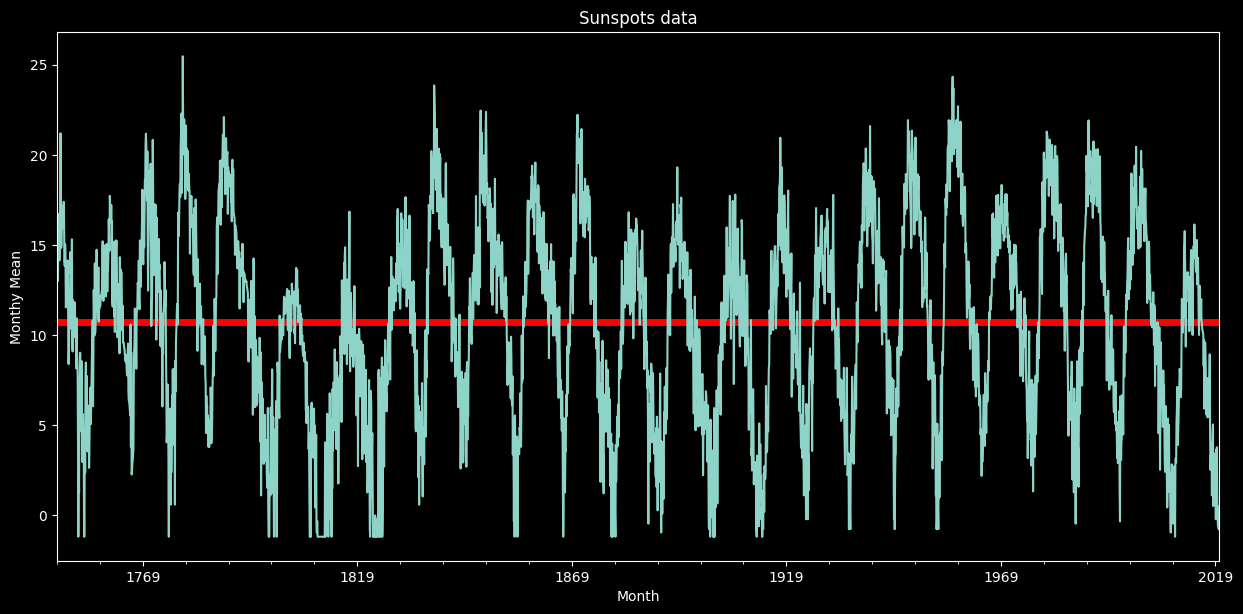

In [323]:
_=transformed_series.plot(title='Sunspots data', ylabel='Monthy Mean')
_=plt.hlines(transformed_series.mean(), label='mean', linewidth=5,
             xmin = sundata.index.min(),
             xmax = sundata.index.max(), color='red')

<b>Given that some values are in the negative, we wont be able to use multiplicative decompising models</b>

In [329]:
sundata_transformed = np.power(sundata, 1/3)
sundata_transformed.head()

MMTS
Month               
1749-01-31  4.589959
1749-02-28  4.707187
1749-03-31  4.886789
1749-04-30  4.527405
1749-05-31  5.213427

## Seasonal/Variation Plot

In [330]:
pltdata = sundata.copy()

In [331]:
pltdata['Year'] = pltdata.index.year
pltdata['Month'] = pltdata.index.month
pltdata.head()

MMTS  Year  Month
Month                         
1749-01-31   96.7  1749      1
1749-02-28  104.3  1749      2
1749-03-31  116.7  1749      3
1749-04-30   92.8  1749      4
1749-05-31  141.7  1749      5

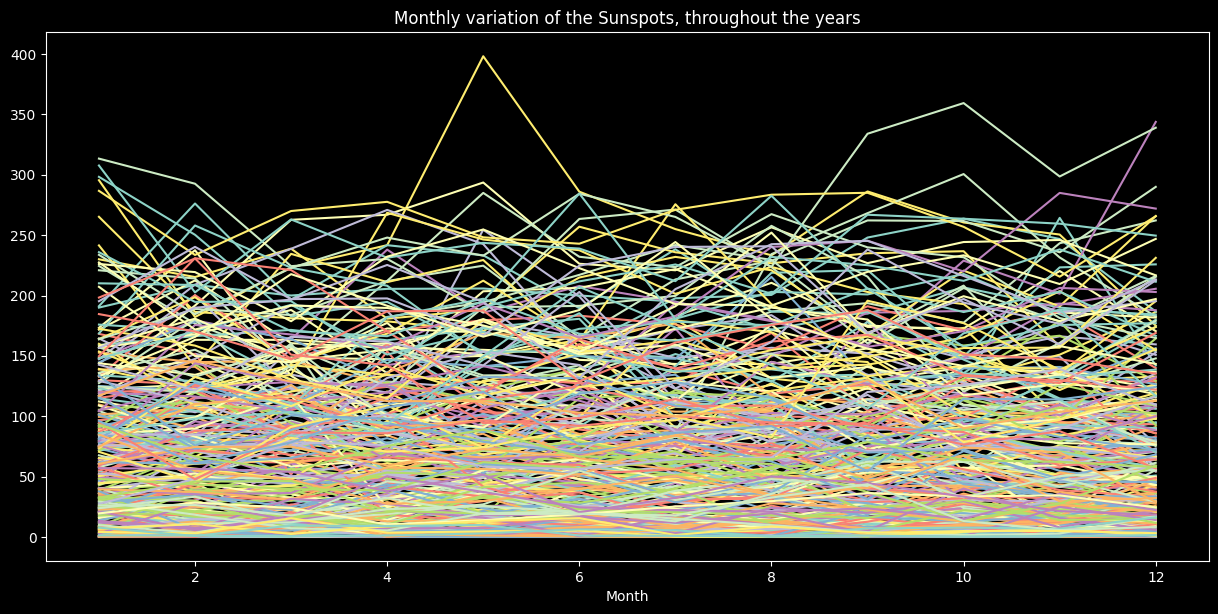

In [332]:
# For checking monthly seasonality
sundata_monthp = pltdata.pivot(index='Month', columns='Year', values='MMTS')
_=sundata_monthp.plot(legend=None,
                      title='Monthly variation of the Sunspots, throughout the years')

## Chop Plot

In [333]:
pltdata = sundata.copy()[7*12:]

MMTS  Period
Month                   
1756-01-31  20.8       0
1756-02-29  11.8       0
1756-03-31   9.0       0
1756-04-30  15.7       0
1756-05-31  20.8       0

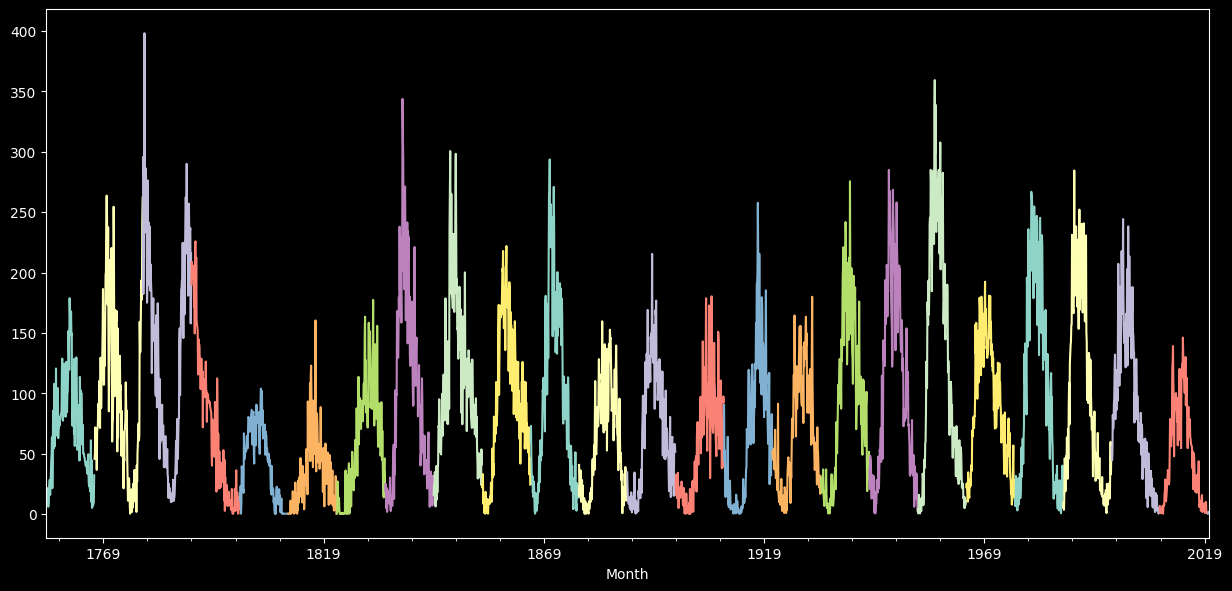

In [334]:
period = 11 # In years
start_date = pltdata.index.min()
def assign_periodlabel(x):
    tdiff = period*365
    _days = (x.name-start_date).days
    return _days//tdiff

pltdata['Period'] = pltdata.apply(lambda x : assign_periodlabel(x), axis=1)
_=pltdata.groupby('Period').MMTS.plot()
pltdata.head()

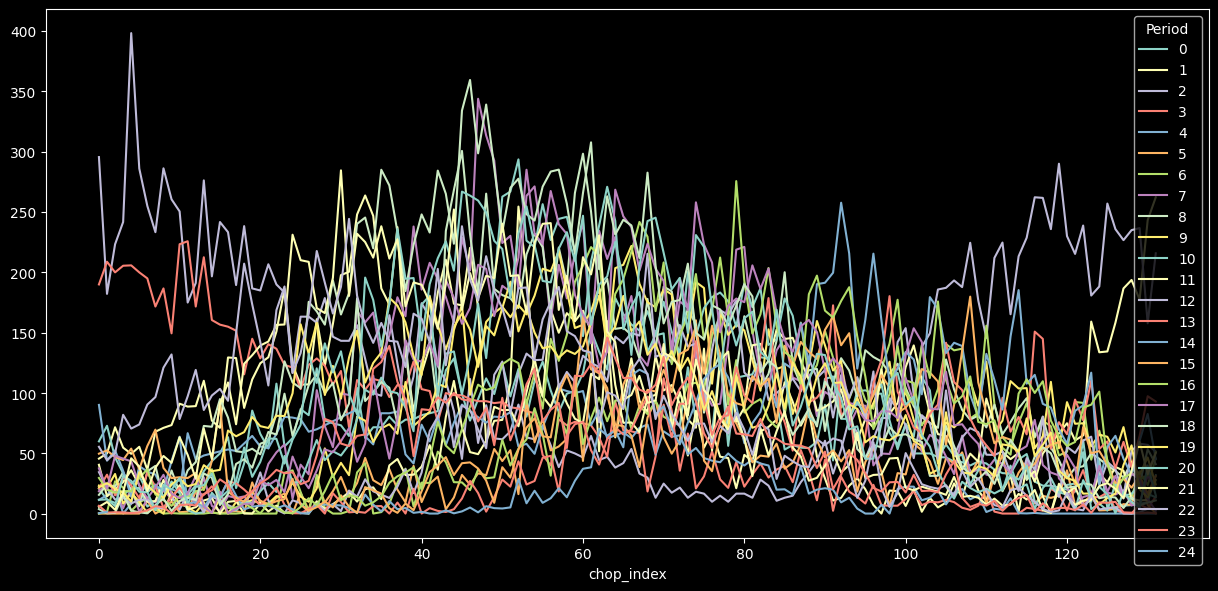

In [335]:
chop_indices = []
for each_period_counts in pltdata.groupby('Period').size().values:
    chop_indices += list(range(each_period_counts))
pltdata['chop_index'] = chop_indices
pltdata_chop = pltdata.pivot(index='chop_index',
                             columns='Period',
                             values='MMTS')
_=pltdata_chop.plot()

## Box  & Violin Plot

See as to which `period` makes the line more stable around the mean, to gauge into the Cyclicity behaviour of the model

In [348]:
pltdata1 = sundata.copy()
pltdata2 = sundata_transformed.copy()

def get_boxp(data, period=10):
    """period is in years"""
    fig,axes = plt.subplots()
    data = data.copy()
    start_date = data.index.min()
    def assign_periodlabel(x):
        tdiff = period*365
        _days = (x.name-start_date).days
        return _days//tdiff
    data['Period'] = data.apply(lambda x : assign_periodlabel(x), axis=1)
    _=sns.boxplot(x='Period',y='MMTS',data=data, ax=axes)
    _=data.groupby('Period').mean().plot(ax=axes, color='red', linewidth=5)
    _=plt.title('Box Plot')

    
def get_violinp(data, period=10):
    """period is in years"""
    data = data.copy()
    fig,axes = plt.subplots()
    start_date = data.index.min()
    def assign_periodlabel(x):
        tdiff = period*365
        _days = (x.name-start_date).days
        return _days//tdiff
    data['Period'] = data.apply(lambda x : assign_periodlabel(x), axis=1)
    _=sns.violinplot(x='Period',y='MMTS',data=data, ax=axes)
    _=data.groupby('Period').mean().plot(ax=axes, color='red', linewidth=5)
    _=plt.title('Box Plot')



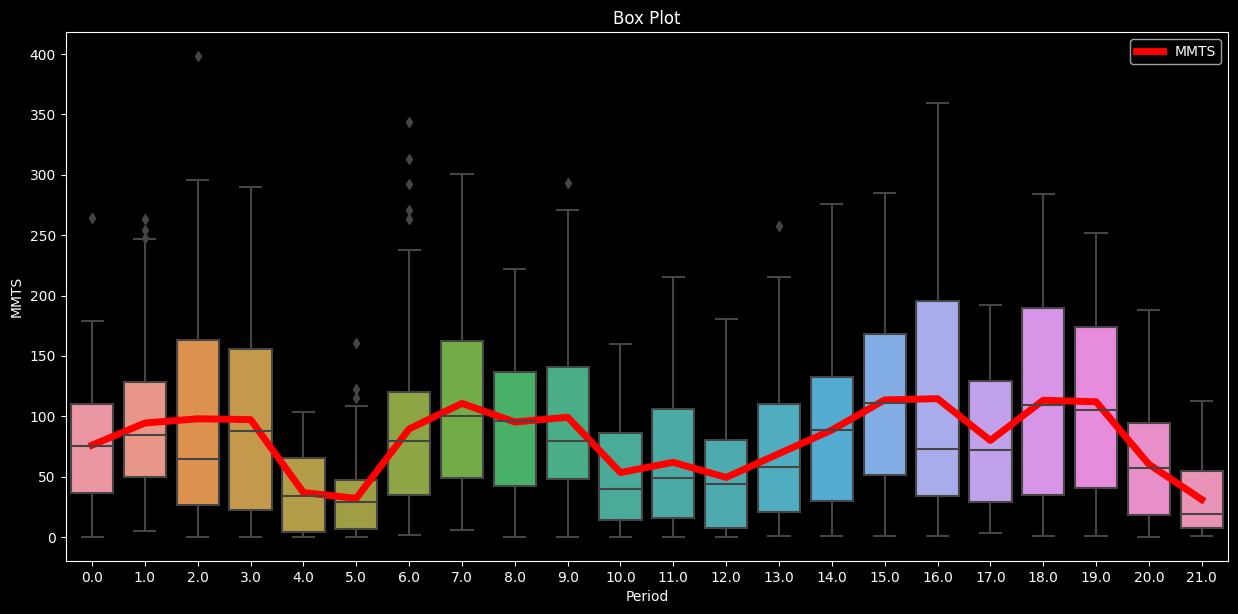

In [349]:
get_boxp(pltdata1, 12+(8/12))

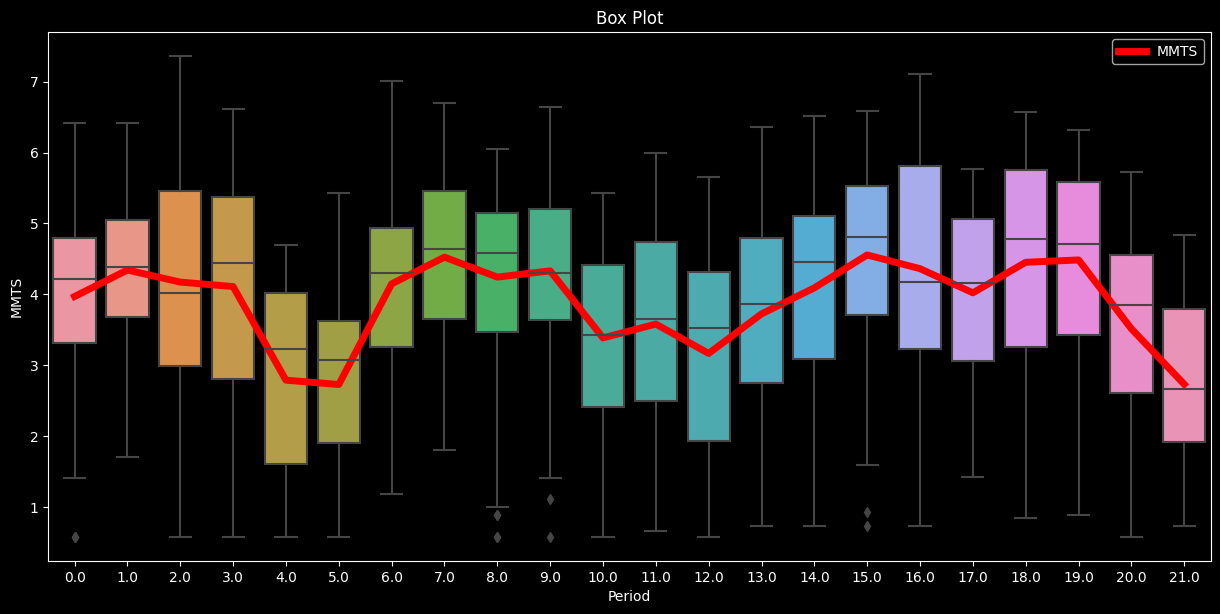

In [350]:
get_boxp(pltdata2, 12+(8/12))

<b>Well, it doesnt looks that the box plot has changed much...., so what has?<b>

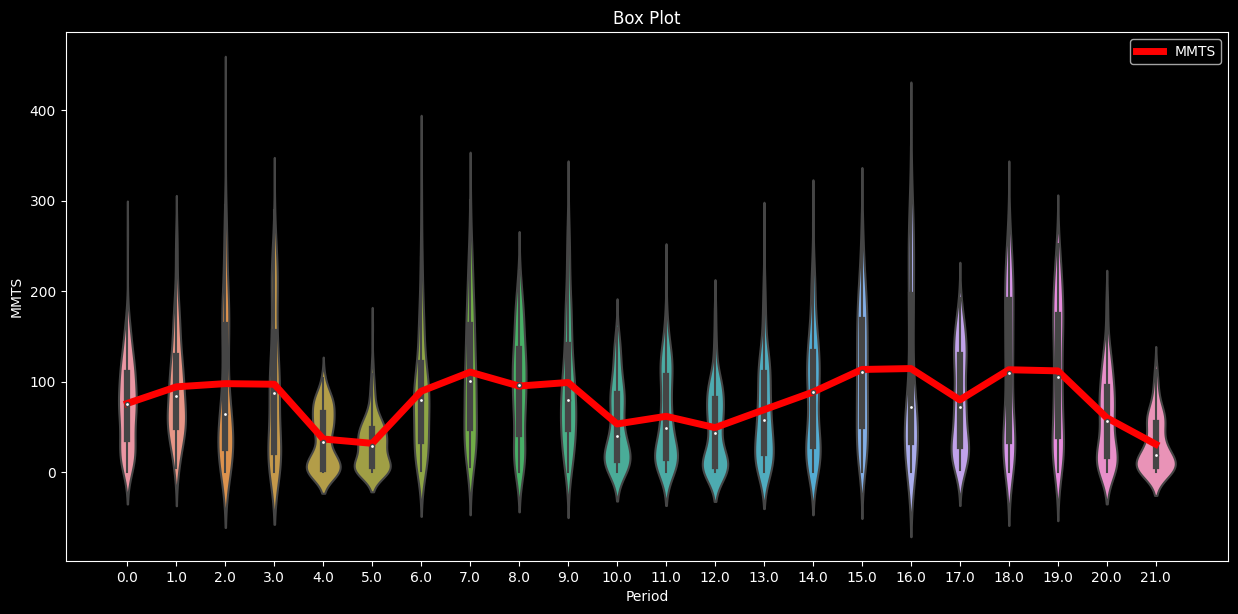

In [351]:
get_violinp(pltdata1, period=12+(8/12))

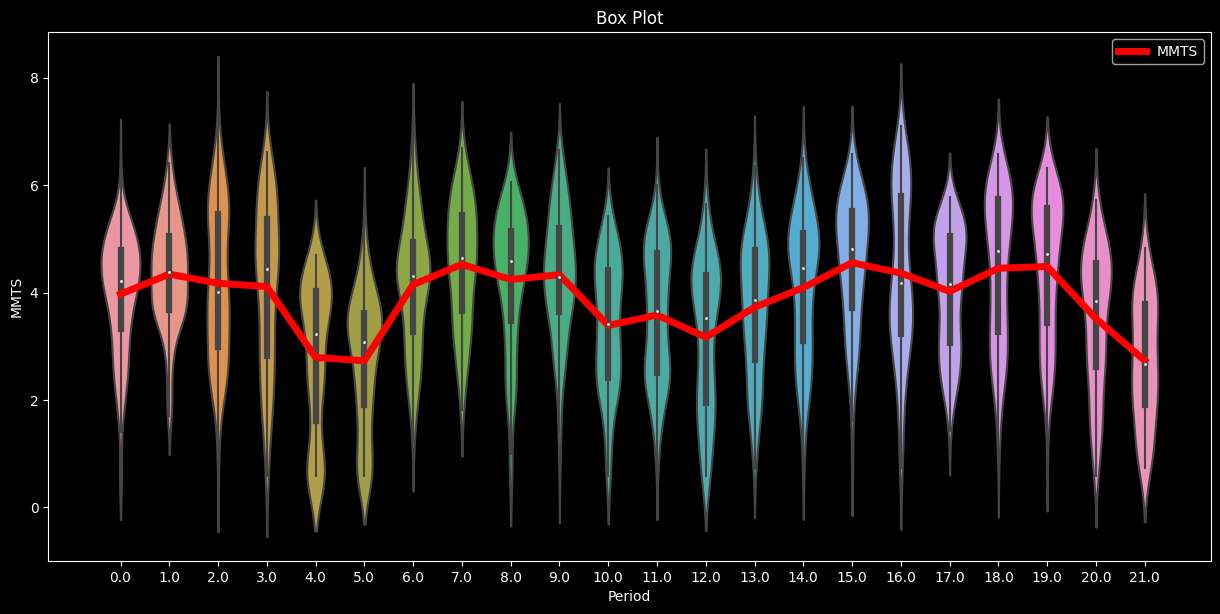

In [352]:
get_violinp(pltdata2, period=12+(8/12))

## Decomposition

The period parameter will be filled by the cyclic componet as observed in the 5.5 section, and then try for 12 to decompose for the yearly frequency.

Look at the extrapolate trend parameter

Trend  Seasonal
Strength  0.176792  0.288109

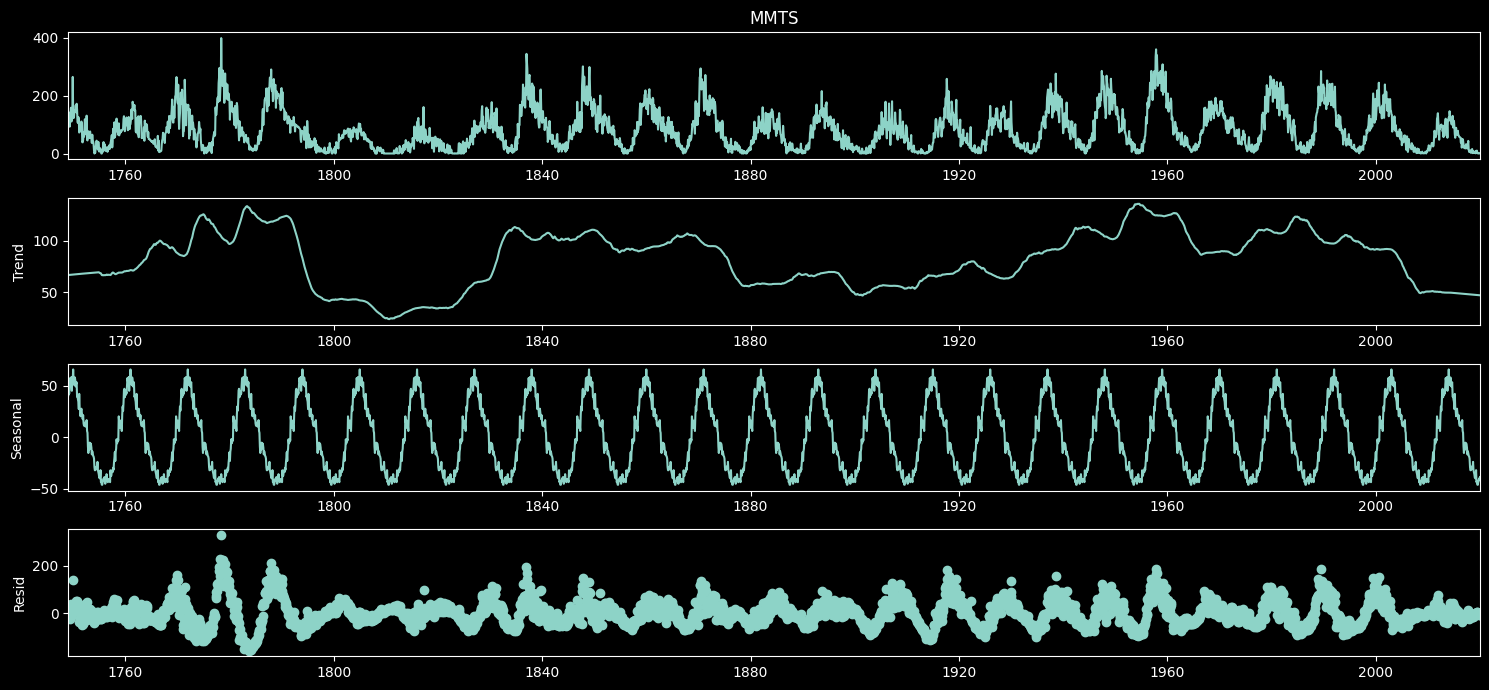

In [353]:
adecomp_obj = seasonal_decompose(sundata.MMTS, model='additive', period=11*12, extrapolate_trend=True)
_ = adecomp_obj.plot()
get_ts_strength(adecomp_obj).T

Trend  Seasonal
Strength  0.999185  0.237728

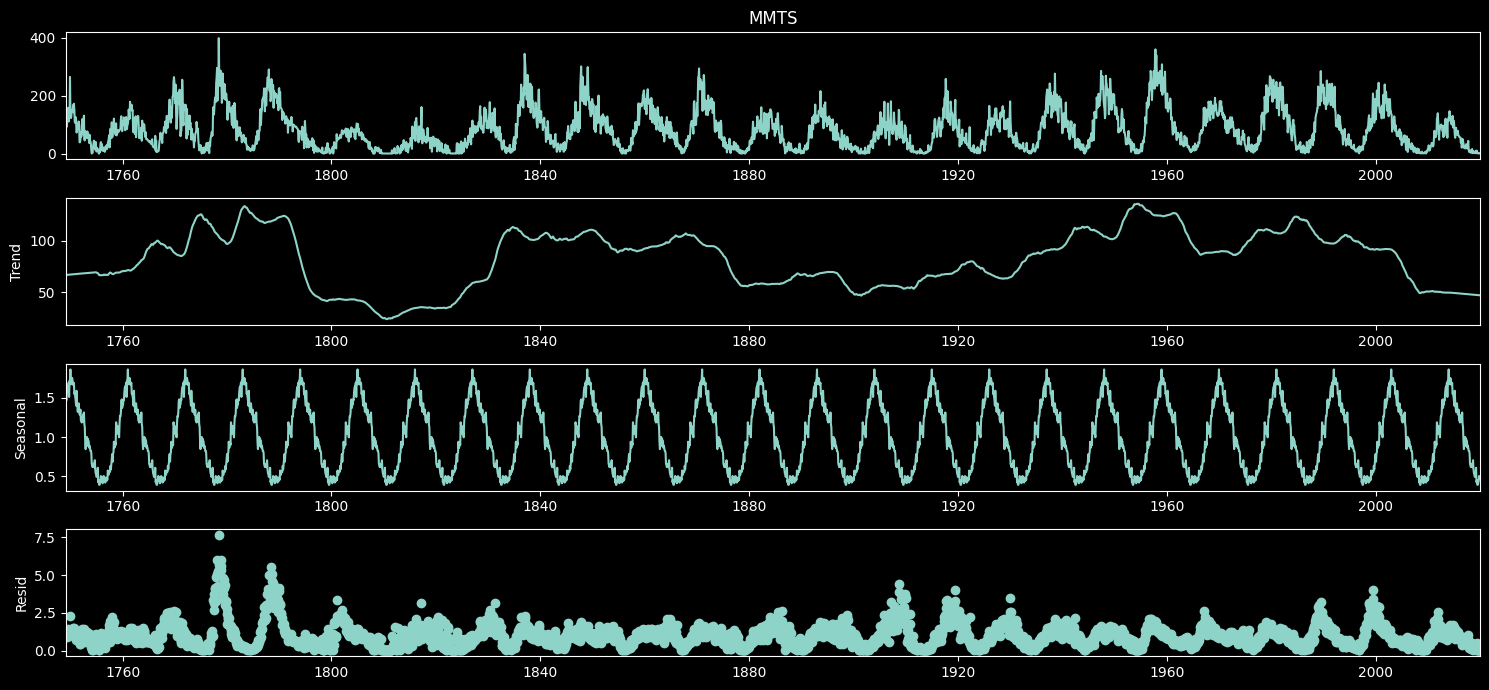

In [354]:
adecomp_obj = seasonal_decompose(sundata.MMTS, model='multiplicative', period=11*12, extrapolate_trend=True)
_ = adecomp_obj.plot()
get_ts_strength(adecomp_obj).T

Trend  Seasonal
Strength  0.230778  0.341806

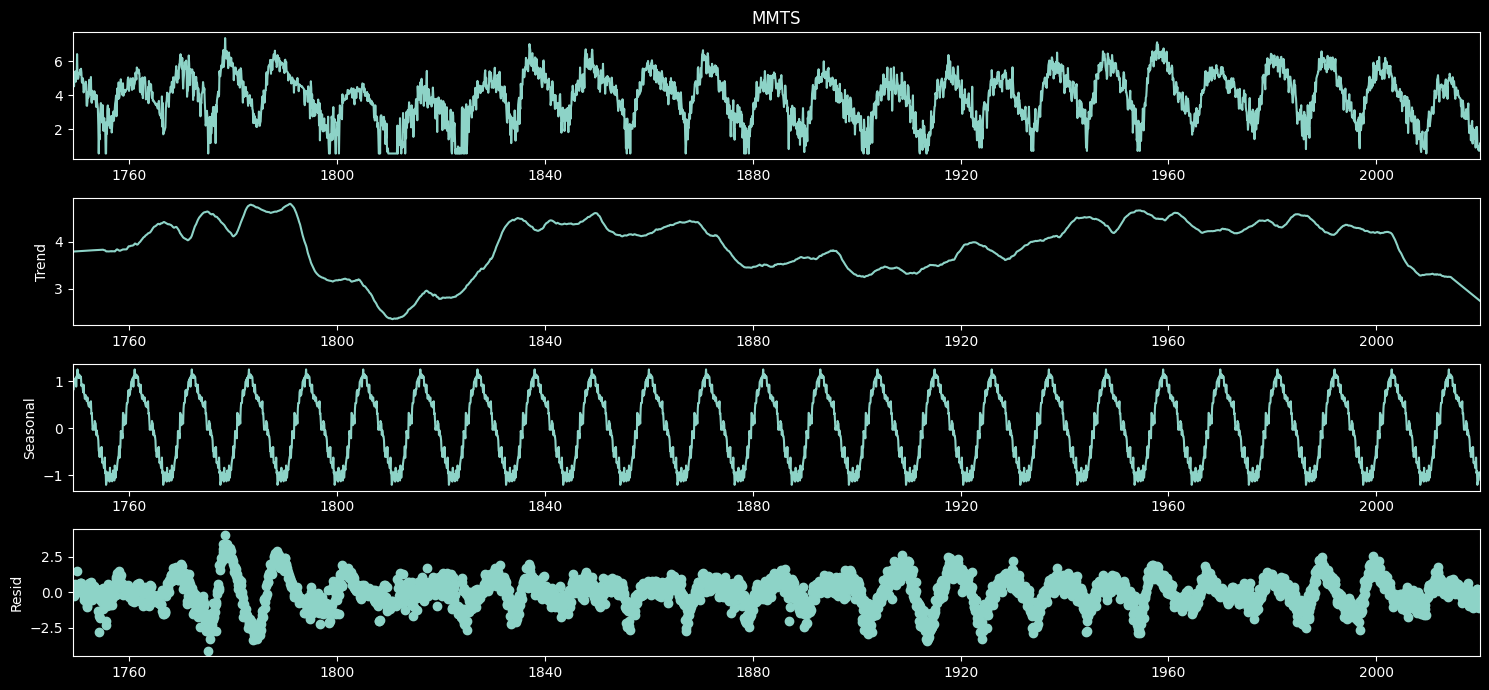

In [355]:
adecomp_obj = seasonal_decompose(sundata_transformed.MMTS,
                                 model='additive',
                                 period=11*12, extrapolate_trend=True)
_ = adecomp_obj.plot()
get_ts_strength(adecomp_obj).T

Trend  Seasonal
Strength  0.791097  0.302563

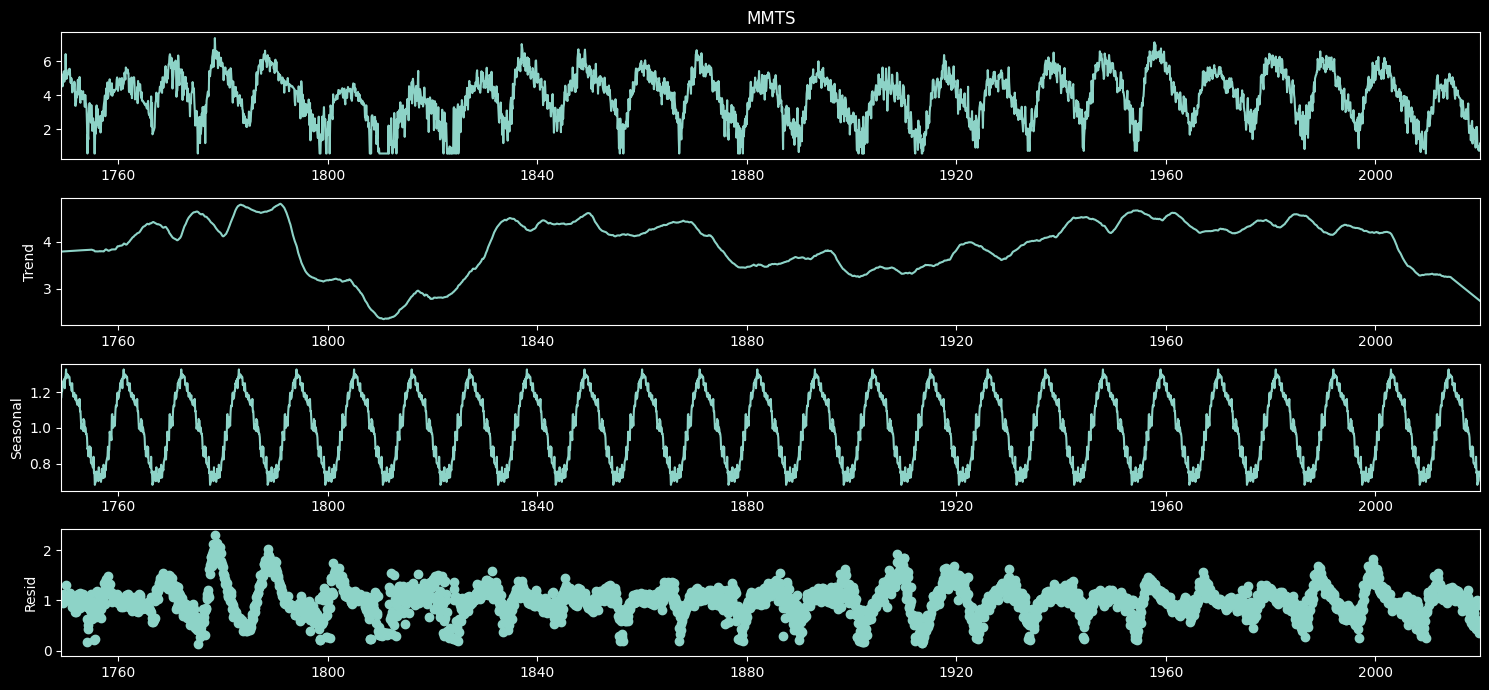

In [356]:
adecomp_obj = seasonal_decompose(sundata_transformed.MMTS,
                                 model='multiplicative',
                                 period=11*12, extrapolate_trend=True)
_ = adecomp_obj.plot()
get_ts_strength(adecomp_obj).T

<b>Since none of the above decompositions gave a promising measure of seasonality</b>
    
Lets try the STL decomposition model

Trend  Seasonal
Strength  0.887779  0.011484

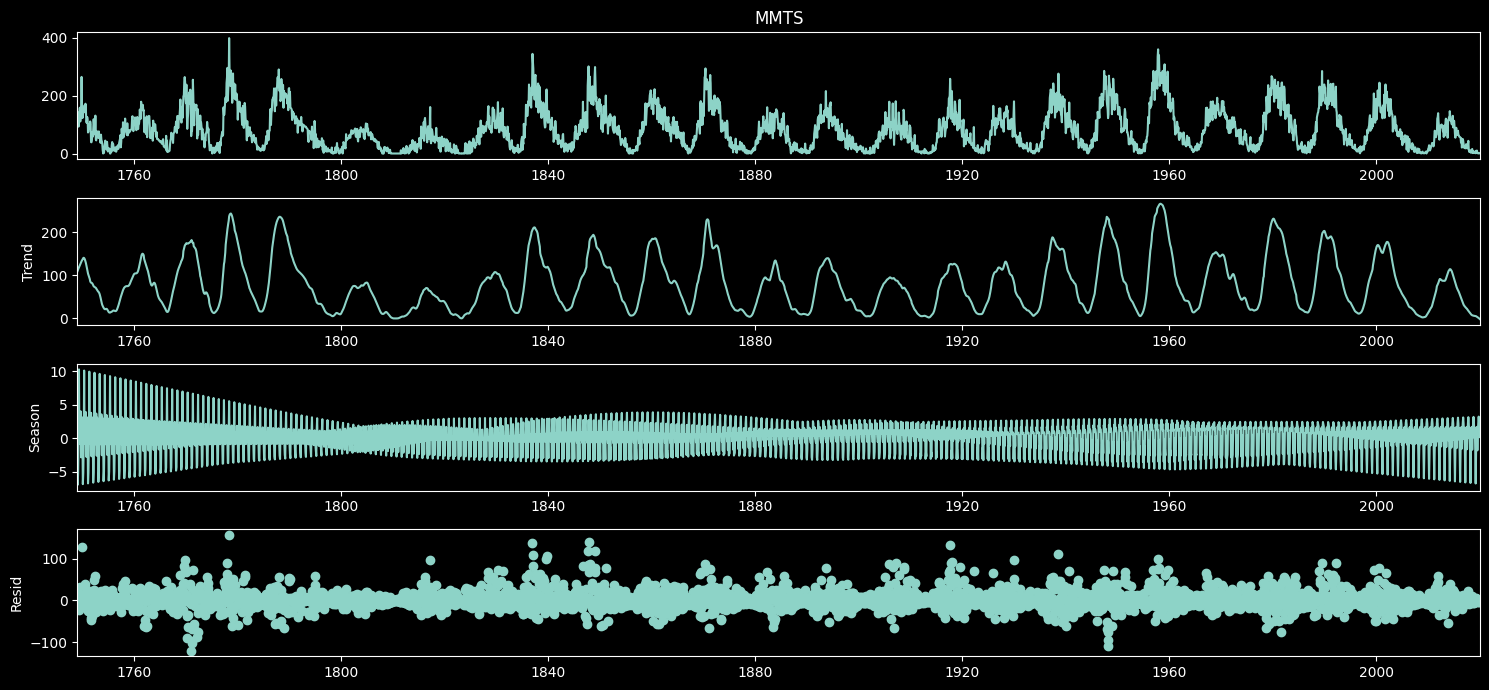

In [14]:
stl = STL(sundata.MMTS, seasonal=10*12-1, robust=True)
res = stl.fit()
fig = res.plot()
get_ts_strength(res).T

# Gauging its Statistics

- Stationarity Test
- Looking in the ACF and PACF
- Distribution Test

<b>Stationarity Test</b>

In [357]:
adf_test(sundata.MMTS)

0
Test Statistic              -1.048121e+01
p-value                      1.212359e-18
#Lags Used                   2.800000e+01
Number of Observations Used  3.223000e+03
Critical Value (1%)         -3.432381e+00
Critical Value (5%)         -2.862437e+00
Critical Value (10%)        -2.567248e+00

In [358]:
adf_test(sundata_transformed.MMTS)

0
Test Statistic              -9.926484e+00
p-value                      2.897836e-17
#Lags Used                   2.600000e+01
Number of Observations Used  3.225000e+03
Critical Value (1%)         -3.432379e+00
Critical Value (5%)         -2.862437e+00
Critical Value (10%)        -2.567247e+00

In [359]:
kpss_test(sundata.MMTS)

0
Test Statistic          0.112224
p-value                 0.100000
Lags Used              36.000000
Critical Value (10%)    0.347000
Critical Value (5%)     0.463000
Critical Value (2.5%)   0.574000
Critical Value (1%)     0.739000

In [360]:
kpss_test(sundata_transformed.MMTS)

0
Test Statistic          0.101916
p-value                 0.100000
Lags Used              36.000000
Critical Value (10%)    0.347000
Critical Value (5%)     0.463000
Critical Value (2.5%)   0.574000
Critical Value (1%)     0.739000

Through the results it seems to be stationary

**A time series with cyclic behavior (but with no trend or seasonality) is stationary. This is because the cycles are not of a fixed length, so before we observe the series we cannot be sure where the peaks and troughs of the cycles will be. That is, the statistical properties of the series like mean, variance and autocorrelation are constant over time.**

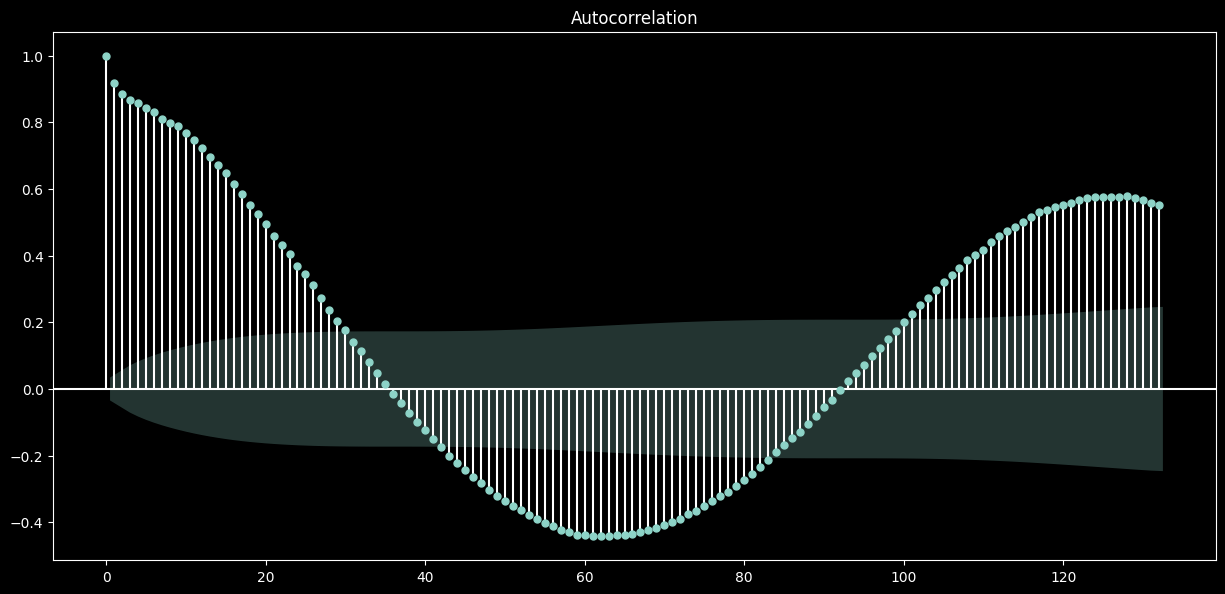

In [361]:
_=plot_acf(sundata.MMTS, lags=11*12)

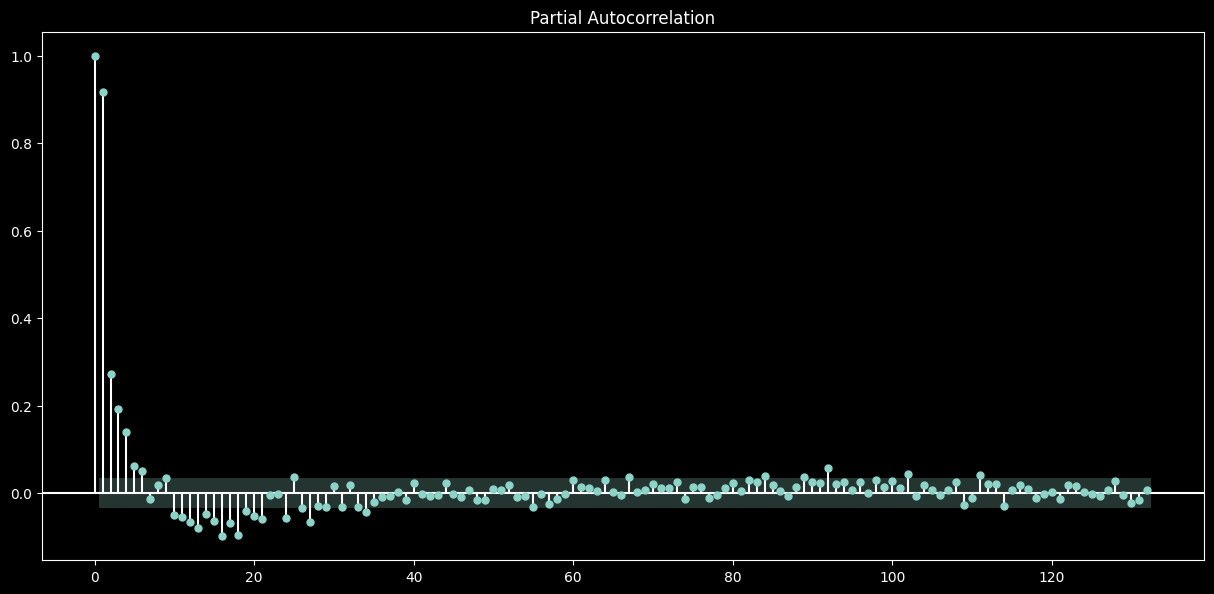

In [362]:
_=plot_pacf(sundata.MMTS, lags=11*12)

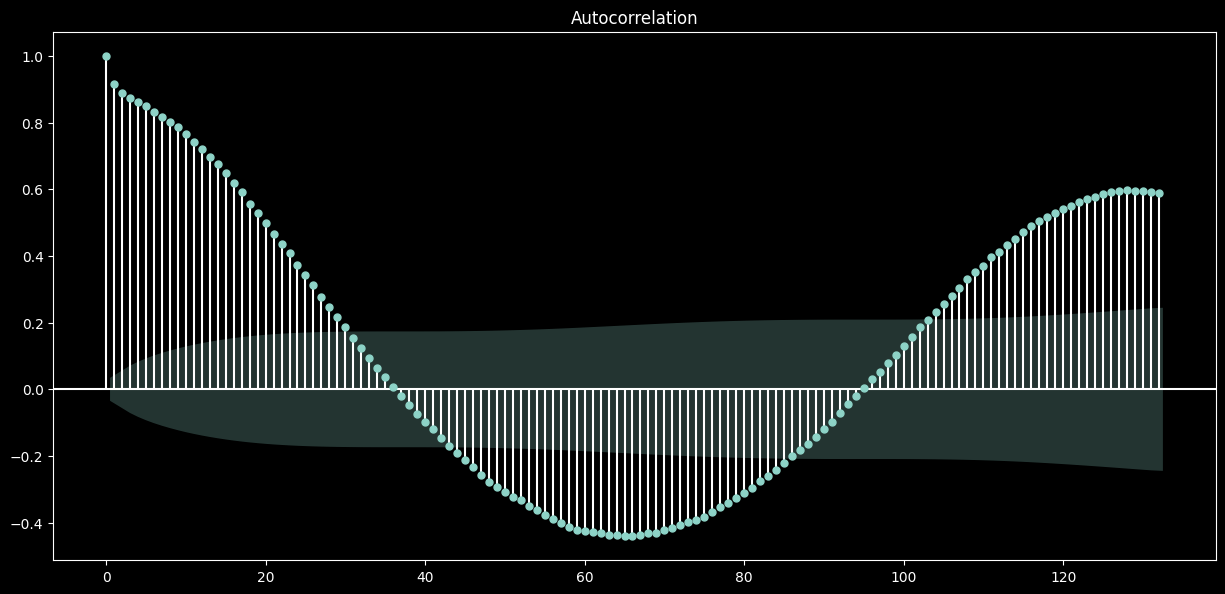

In [363]:
_=plot_acf(sundata_transformed.MMTS, lags=11*12)

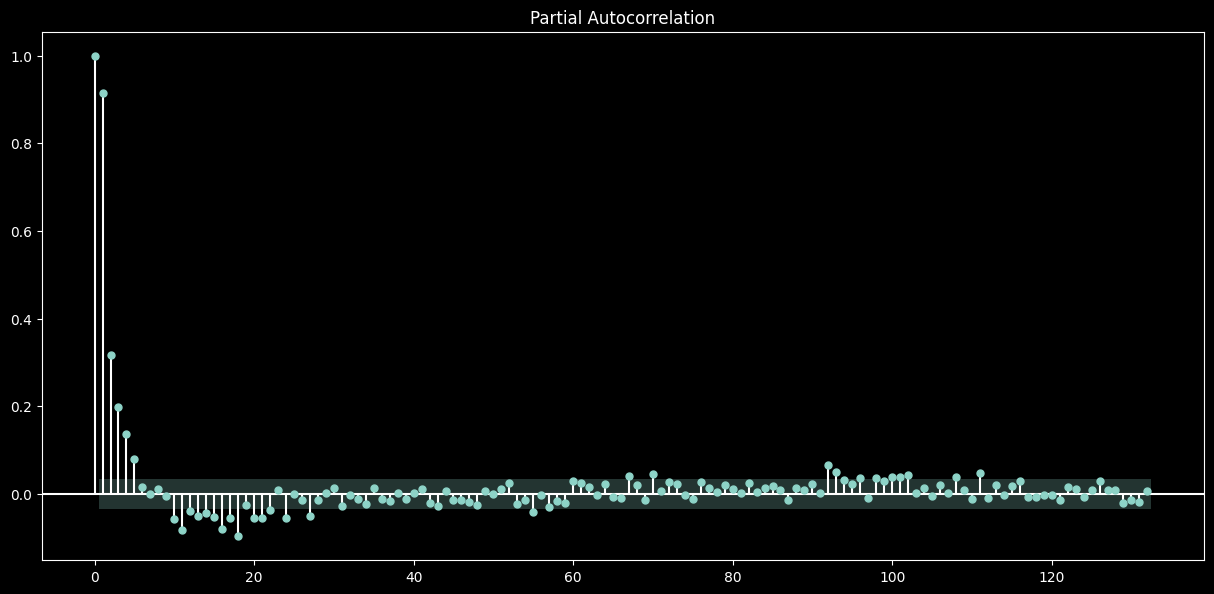

In [364]:
_=plot_pacf(sundata_transformed.MMTS, lags=11*12)

# Preparing Modelling Function

As discussed in the previos notebook, the best methodology to predict a time series is via the `Rolling-Origin` forecast, 

i.e ***Utilise the fact that time series data generation is a `frequency` based process and we will get the data accordingly, so it will be best to use that data to make the forecasts***

In [19]:
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arma_mle import Arma

In [20]:
# AN EXPLANATORY TEMPLATE
def modelling_framework(data, model, model_params, 
                 target_col, feature_cols,
                 test_start, cv_window, ahead_offest,
                 metric='MAPE', ahead_offest_freq='days'):
    
    # Initialisations
    cvDF = pd.DataFrame(columns = ['Actual', 'Forecast', metric])
    testDF = pd.DataFrame(columns=['Actual', 'Forecast', metric])
    
    model = copy.deepcopy(model)
    
    modelling_data = data.copy()
    modelling_data.sort_index(inplace=True)
    
    training_data = data[data.index<test_start].copy()
    testing_data = data[data.index>=test_start].copy()

    train_start = training_data.index[0]
    
    test_start = pd.to_datetime(test_start)
    test_end = modelling_data.index[-1]
    
    # Picking the Metrics
    if metric == 'MAPE':
        metric_func = lambda y,yhat: np.round(100*(abs(np.array(y)-np.array(yhat))/np.array(y)),2)
    elif metric == 'MSE':
        metric_func = lambda y,yhat: np.round(100*(abs(np.array(y)-np.array(yhat))/np.array(y)),2)
    
    
    # Cross Validation Loop
    for cv_date in training_data.index[-cv_window:]:
        train_end = cv_date-ahead_offest
        
        # Filter the data
        _train_data = training_data.truncate(before=train_start, after=train_end)
        _cv_data = training_data.loc[cv_date].to_frame().T
        
        if feature_cols:
            # Multivariate
            pass
        else:
            # Univariate
            if 'statsmodels' in str(model):
                # Update Model Params Based on library
                model_params['endog'] = _train_data[target_col]
                modeldef = model(**model_params)
                
                fitted_model = modeldef.fit()
                _forecast = fitted_model.predict(start=cv_date, end=cv_date).values[0]
                _actual = _cv_data[target_col].values[0]

        # Update Metric Sheets
        cvDF.loc[cv_date, 'Actual'] = _actual
        cvDF.loc[cv_date, 'Forecast'] = _forecast
        cvDF.loc[cv_date,  metric] = metric_func(_actual, _forecast)
    
    
    # Testing - Using the last fitted_model
    if 'statsmodels' in str(model):
        testDF['Actual'] = testing_data[target_col]
        testDF['Forecast'] = fitted_model.predict(start=test_start, end=test_end)
        testDF[metric] = testDF.apply(lambda x : metric_func(x.Actual, x.Forecast), axis=1)
    
    # Prepare Overall Metric
    overallDF = pd.DataFrame([cvDF[metric].mean(), testDF[metric].mean()],
                             columns=['Overall '+metric],
                             index=['CV', 'Test'])
    
    return cvDF, testDF, overallDF, fitted_model


In [21]:
from helperhandler import ro_framework

# AR Model

In [543]:
mdata = sundata_transformed.copy()
testart = '1966-01-31'
respacket=ro_framework(data = mdata, model = AutoReg, model_params = {'lags':[1,2,3,4,5,6,7,12,14,18,132]},
                       back_transform_func = lambda x : x**3,
                       test_start = testart, cv_window = 122,
                       target_col = 'MMTS', feature_cols = [],
                       ahead_offest = pd.DateOffset(months=12),
                       test_predict=True, test_roll=False,
                       metric='MAPE', debug=False, ahead_offest_freq='months')
cv_DF, test_DF, overall_DF, fitted_model = respacket

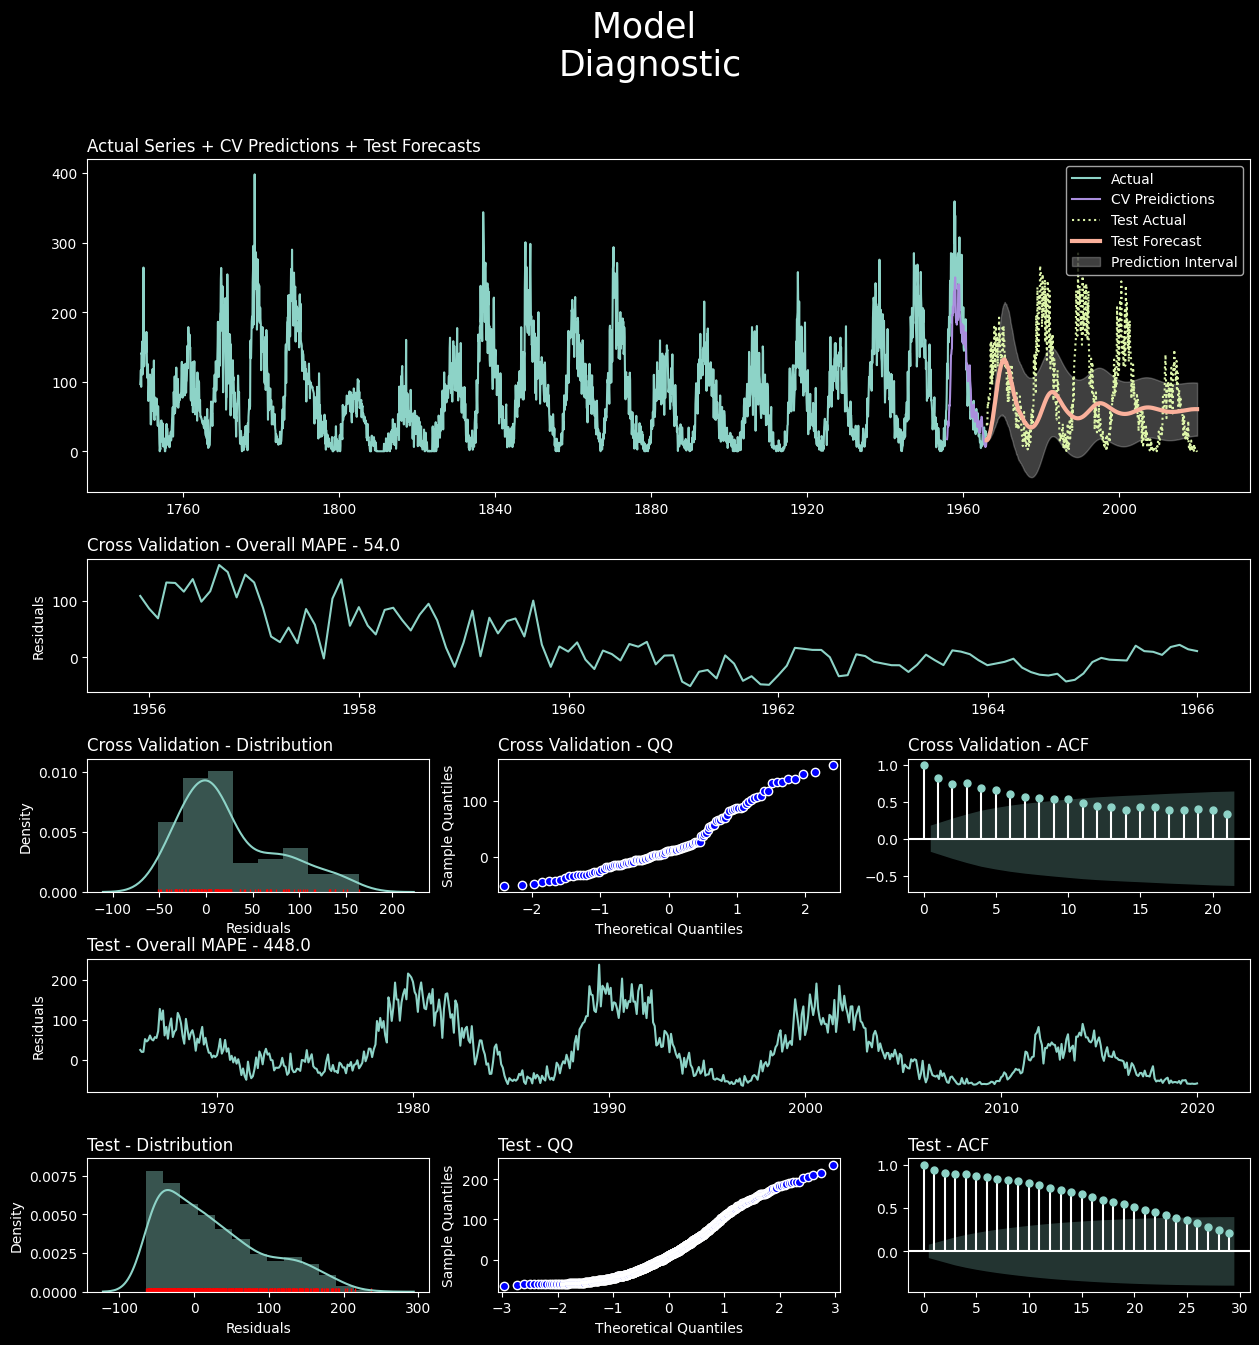

In [544]:
residual_diagnostic(respack=respacket,
                    training_target=sundata[sundata.index<testart].MMTS)

# ARIMA Model

In [500]:
testart = '1966-01-31'
respacket=ro_framework(data = sundata, model = ARIMA,
                       model_params = {'order':([1,3], 0, [1])},
                       test_start = testart, cv_window = 3,
                       target_col = 'MMTS', feature_cols = [],
                       ahead_offest = pd.DateOffset(months=1),
                       test_predict=True, test_roll=False,
                       metric='MAPE', debug=False, ahead_offest_freq='months')
cv_DF, test_DF, overall_DF, fitted_model = respacket

In [501]:
fitted_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                SARIMAX Results                                
===============================================================================
Dep. Variable:                    MMTS   No. Observations:                 2603
Model:             ARIMA([1, 3], 0, 1)   Log Likelihood              -12146.108
Date:                 Fri, 04 Dec 2020   AIC                          24302.217
Time:                         03:50:39   BIC                          24331.539
Sample:                     01-31-1749   HQIC                         24312.840
                          - 11-30-1965                                         
Covariance Type:                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         80.6249     14.681      5.492      0.000      51.851     109.399
ar.L1          0.8741      0.025     35.312      0.000       0.826       0.923
ar.L3          0.0959      0.023      4.102      0.000       0.050       0.142
ma.L1         -0.3209      0.032    -10.053      0.000      -0.383      -0.258
sigma2       661.5726     11.371     58.180      0.000     639.286     683.860
===================================================================================
Ljung-Box (L1) (Q):                   1.76   Jarque-Bera (JB):              1694.95
Prob(Q):                              0.18   Prob(JB):                         0.00
Heteroskedasticity (H):               1.07   Skew:                             0.67
Prob(H) (two-sided):                  0.30   Kurtosis:                         6.72
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

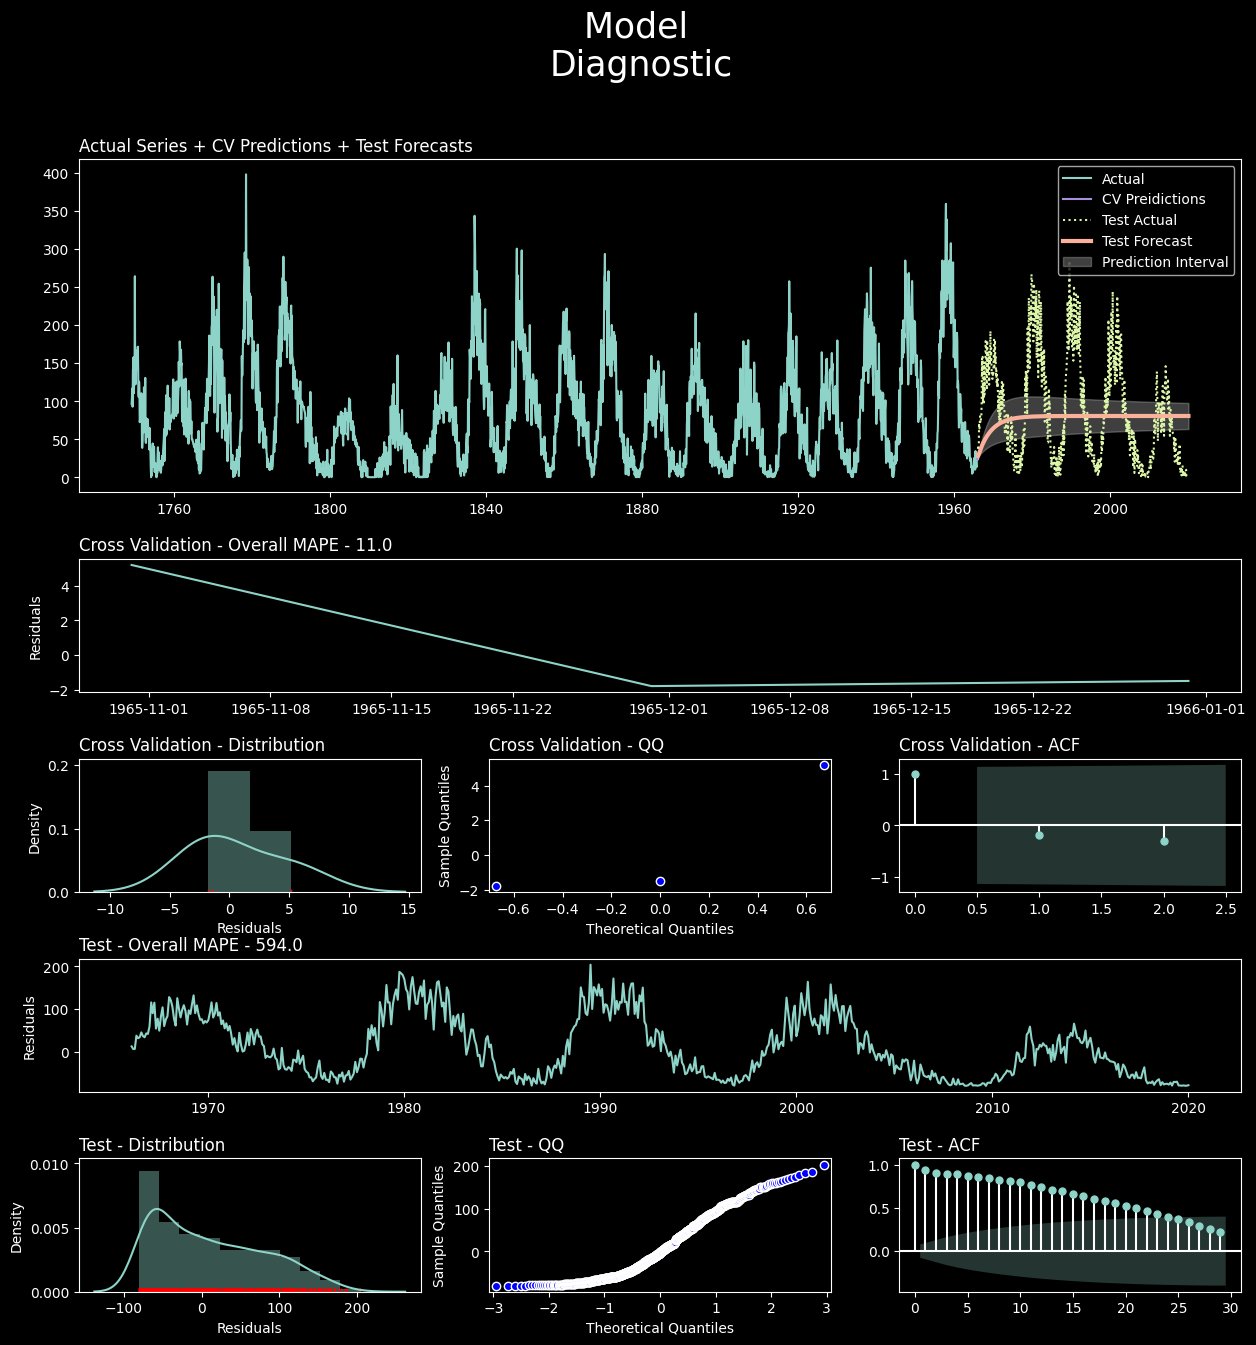

In [502]:
residual_diagnostic(respack=respacket,
                    training_target=sundata[sundata.index<testart].MMTS)

# SARIMA Model

In [235]:
testart = '1966-01-31'
respacket=ro_framework(data = sundata, model = SARIMAX, model_params = {'order':(2,0,2),
                                                                        'seasonal_order':(1, 0, 1, 132)},
                       test_start = testart, cv_window = 3,
                       target_col = 'MMTS', feature_cols = [],
                       ahead_offest = pd.DateOffset(months=1),
                       test_predict=True, test_roll=False,
                       metric='MAPE', debug=False, ahead_offest_freq='months')
cv_DF, test_DF, overall_DF, fitted_model = respacket

[autoreload of Cython.Compiler.StringEncoding failed: Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 410, in superreload
    update_generic(old_obj, new_obj)
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 347, in update_generic
    update(a, b)
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 317, in update_class
    update_instances(old, new)
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 280, in update_instances
    ref.__class__ = new
TypeError: __class__ ass

KeyboardInterrupt: 

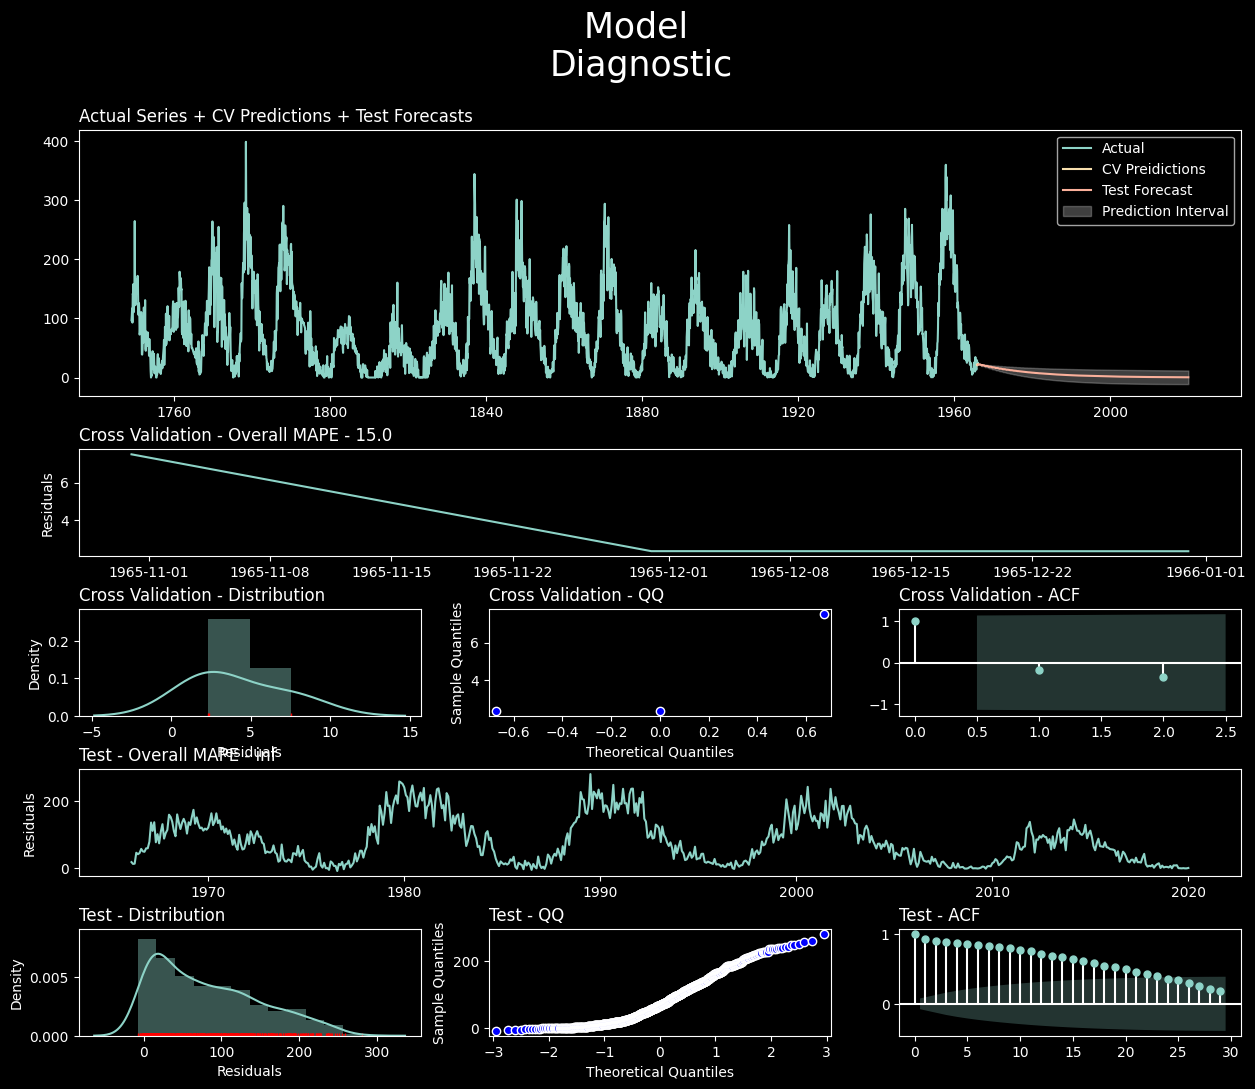

In [221]:
residual_diagnostic(respack=respacket,
                    training_target=sundata[sundata.index<testart].MMTS)

# Prophet Model

Research Paper : [Forecasting at Scale](https://peerj.com/preprints/3190/)

Prophet is a GAM type model, **G**eneralized **A**dditive **M**odel, a model which can be represented as :- 

\begin{equation}
    y_{t} = piecewise\ trend(t) + seasonality(t) + holiday\ effects(t) + i.i.d\ noise(t)
\end{equation}

$piecewise\ trend(t) \Rightarrow$ : Corresponds to L1-Regularized Trend shifts 

$seasonality(t) \Rightarrow$ : Corresponds to Fourier Series

$holiday\ effects(t) \Rightarrow$ : Dummy Variable

$i.i.d\ noise(t) \Rightarrow$ : Classical Time Series Model



In [568]:
  
class ProphetObjectGenerator:
    def __init__(self):
        self.prophet_model = None
        
    def get_pmodelinstance(self):
        print('here')
        self.prophet_model = Prophet(yearly_seasonality=True,weekly_seasonality=False,daily_seasonality=False)
        return self.prophet_model
        
    def fit(self):
        pass
        
    def predict(self):
        pass

In [569]:
mdata = sundata_transformed.copy()
testart = '1966-01-31'

respacket=ro_framework(data = mdata, model = ProphetWrapper(),
                       back_transform_func = lambda x : x**3,
                       test_start = testart, cv_window = 3,
                       target_col = 'MMTS', feature_cols = [],
                       ahead_offest = pd.DateOffset(months=12),
                       test_predict=True, test_roll=False,
                       metric='MAPE', debug=False, ahead_offest_freq='months')
cv_DF, test_DF, overall_DF, fitted_model = respacket

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


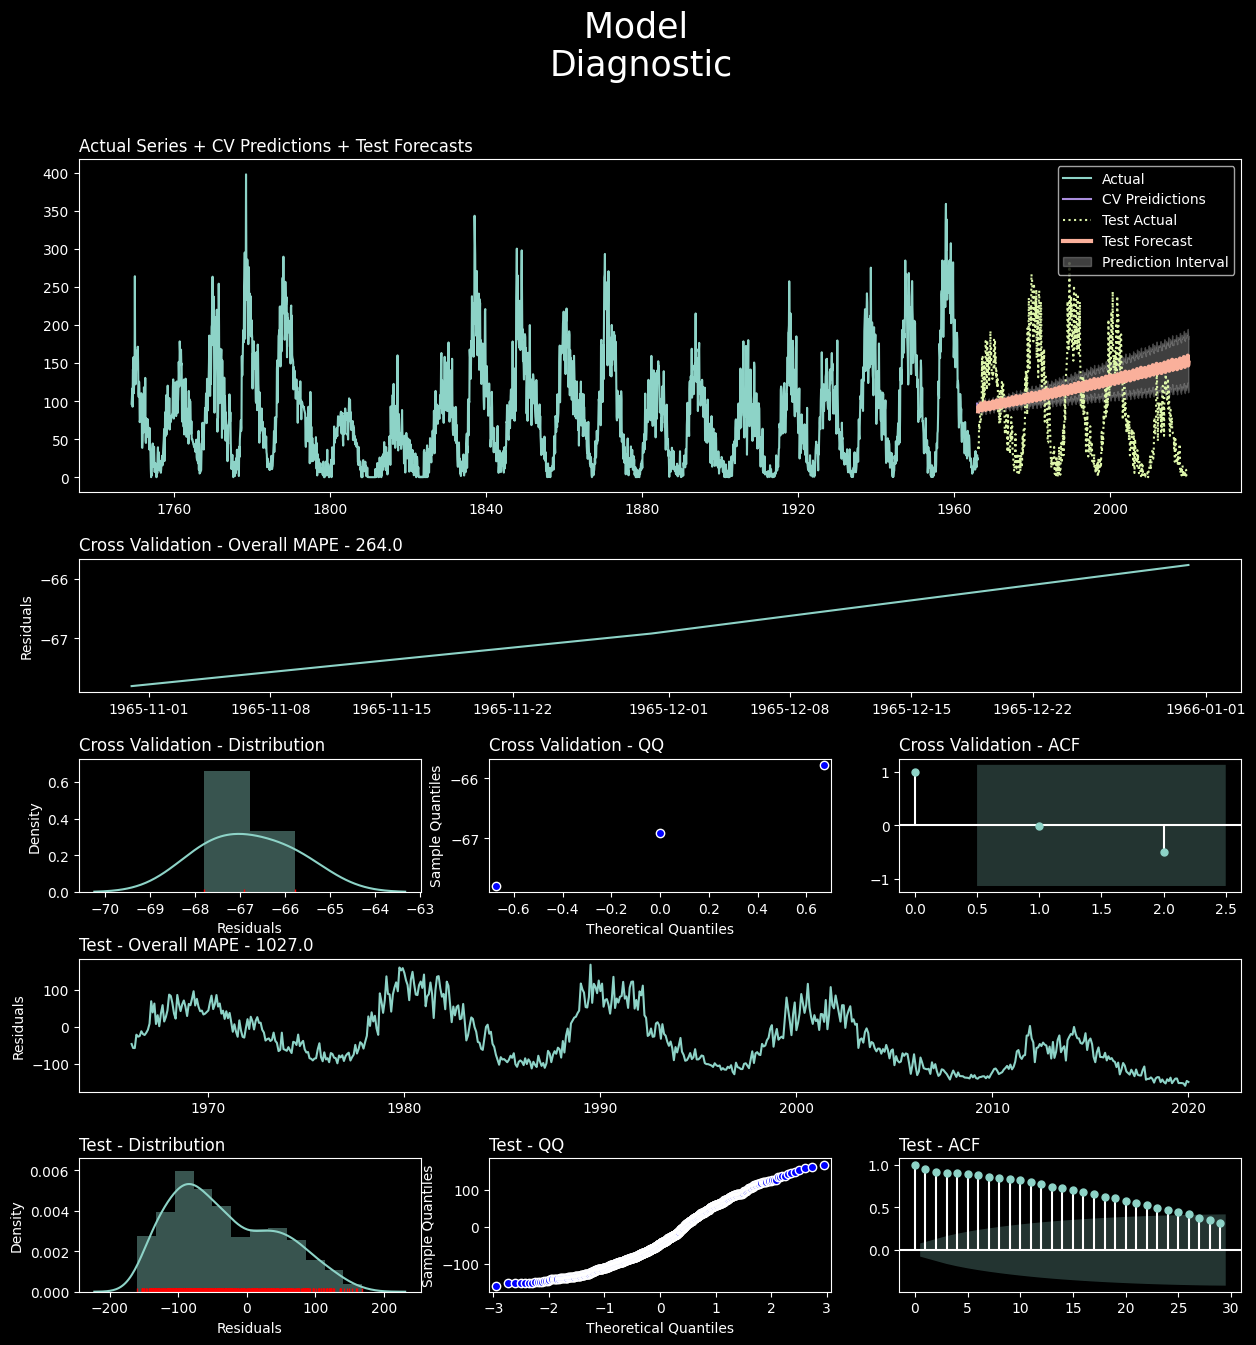

In [570]:
residual_diagnostic(respack=respacket,
                    training_target=sundata[sundata.index<testart].MMTS)

In [ ]:
mdata = sundata_transformed.copy()
testart = '1966-01-31'
prophet_model = Prophet(yearly_seasonality=False, daily_seasonality=False, weekly_seasonality=False)
prophet_model.add_seasonality(name='cycle', period=122, fourier_order = 50)
prophet_model.add_seasonality(name='ar', period=2, fourier_order = 2)

respacket=ro_framework(data = mdata, model = prophet_model,
                       model_params = {'lags':132},
                       back_transform_func = lambda x : x**3,
                       test_start = testart, cv_window = 122,
                       target_col = 'MMTS', feature_cols = [],
                       ahead_offest = pd.DateOffset(months=12),
                       test_predict=True, test_roll=False,
                       metric='MAPE', debug=False, ahead_offest_freq='months')
cv_DF, test_DF, overall_DF, fitted_model = respacket

In [ ]:
residual_diagnostic(respack=respacket,
                    training_target=sundata[sundata.index<testart].MMTS)

# Custom Model

Using Fourier Trnasform for the seasonal component

# Introduction to ts-mad

<img src='../Materials/tsmad_logo.png' width='400'>

`ts-mad` stands for - Time Series-Mini Analysis Dashboard,

It is primarily for creating and embedding a mini-dashboard, especially catering to the time-series data analysis

NOTE : This project is still in its beta-phase, were there to be any issues, kindly raise them on - [Github Issues](https://github.com/ag-ds-bubble/ts-mad/issues)

In [ ]:
import tsmad as tmd
tboard = tmd.TsmadBoard(tsdata=sundata[-500:].copy(),
                       data_desc=dataobj.long_description, 
                       target_columns=['MMTS'], dt_freq='M',
                       freq_conv_agg = 'mean', force_interactive=True)

In [ ]:
tboard.get_board()

# Random Testing Space

In [555]:
test_DF

Actual    Forecast      MAPE
Month                                   
1966-01-31    40.3   86.793327    115.37
1966-02-28    35.3   92.579986    162.27
1966-03-31    36.4   93.854183    157.84
1966-04-30    69.0   90.274241     30.83
1966-05-31    64.2   90.798375     41.43
...            ...         ...       ...
2019-08-31     0.5  152.603779  30420.76
2019-09-30     1.1  154.178742  13916.25
2019-10-31     0.4  159.940973  39885.24
2019-11-30     0.5  146.926681  29285.34
2019-12-31     1.6  150.801977   9325.12

[648 rows x 3 columns]

In [ ]:
# from helperhandler import dataHolder
# dataHolder.load_data()
# dataobj = dataHolder.bucket['sunspots']
# sundata = dataobj.data.copy()

In [ ]:
# %load_ext autoreload
# %autoreload 2
# import tsmad as tmd
# from tsmad import TSMAD_CONFIGS

In [ ]:
# tboard = tmd.TsmadBoard(tsdata=sundata[-500:].copy(),
#                        data_desc=dataobj.long_description, 
#                        target_columns=['MMTS'], dt_freq='M',
#                        freq_conv_agg = 'mean')
# TSMAD_CONFIGS['plotting.default_engine'] = 'Interactive'
# tboard.get_board()

In [ ]:
_pred_date = ''
modeldef = ARIMA(sundata.MMTS, order=(1,0,1))
fitted_model = modeldef.fit()
_forecast = fitted_model.predict(start=pred_date, end=pred_date).values[0]
_actual = _pred_data[target_col].values[0]

In [443]:
tdata=sundata_transformed.copy()
tdata=tdata.reset_index().rename(columns={'Month':'ds', 'MMTS':'y'})
tdata

ds         y
0    1749-01-31  4.589959
1    1749-02-28  4.707187
2    1749-03-31  4.886789
3    1749-04-30  4.527405
4    1749-05-31  5.213427
...         ...       ...
3247 2019-08-31  0.793701
3248 2019-09-30  1.032280
3249 2019-10-31  0.736806
3250 2019-11-30  0.793701
3251 2019-12-31  1.169607

[3252 rows x 2 columns]

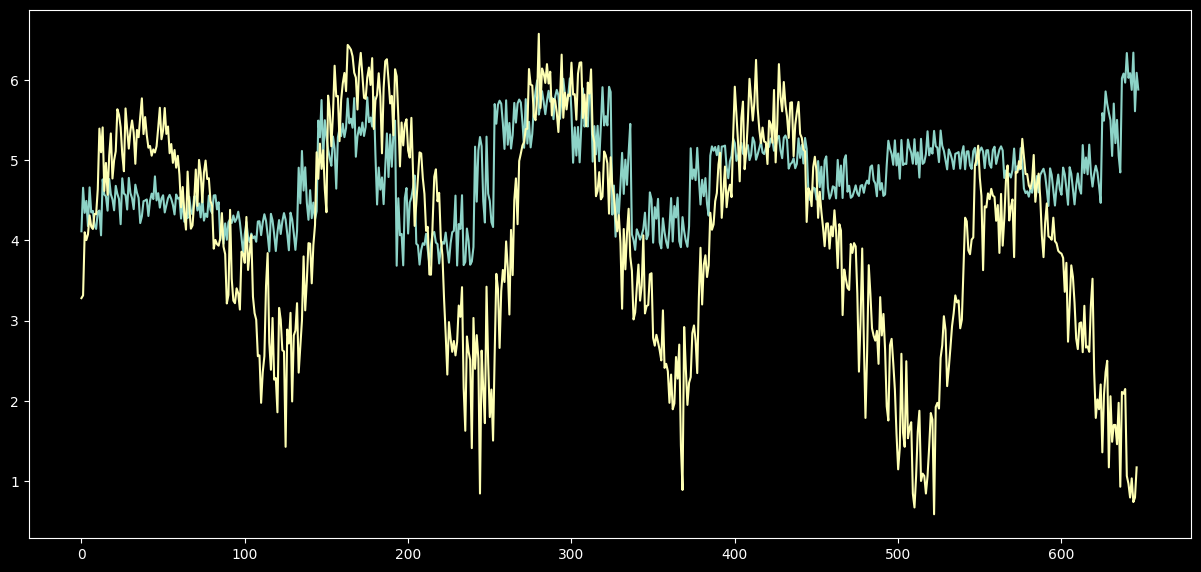

In [571]:
fdata = pd.DataFrame(pd.date_range(testart, '2019-12-31', freq='M'),
                     columns=['ds'])

t=Prophet(yearly_seasonality=False, daily_seasonality=False, weekly_seasonality=False)
t.add_seasonality(name='cycle', period=122, fourier_order = 50)
t.add_seasonality(name='ar', period=2, fourier_order = 2)

t.fit(tdata[:-647])
tp=t.predict(fdata)
plt.plot(tp.yhat)
plt.plot(tdata[-647:].reset_index().y)

KeyError: 'ds'

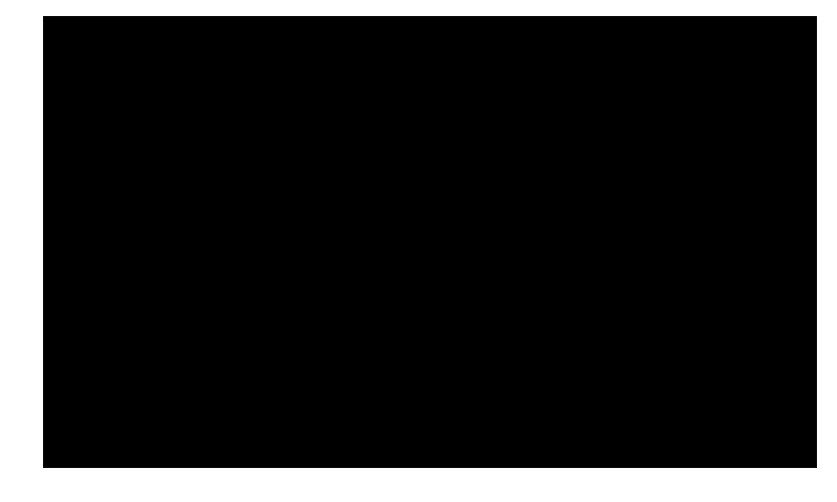

In [474]:
t.plot(t.predict_seasonal_components(fdata))

In [518]:
t.predict(tdata[:-647])

Exception: Prophet object can only be fit once. Instantiate a new object.